In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
dataDirectory = "../Datasets/GDP_PHW(productivity).csv"
rawData = pd.read_csv(dataDirectory, header=0, nrows=None)

In [3]:
# splits the data into two distinct dataFrames: one with absolute GDP per hour worked values and another with values in relation to each country's GDP per hour worked in 2015 (which is scaled to be 100)

dataWithAbsoluteValues = rawData.copy()
dataWithIndexValues = rawData.copy()

for row in range(rawData.shape[0]):
    if "USD" in rawData.iloc[row]['MEASURE']:
        dataWithIndexValues.drop(row, axis=0, inplace=True)
    else:
        dataWithAbsoluteValues.drop(row, axis=0, inplace=True)

dataWithAbsoluteValues.reset_index(inplace=True, drop=True)
dataWithIndexValues.reset_index(inplace=True, drop=True)

In [4]:
# puts the data in an easier to use format (each row contains a specific country's absolute GDP per hour worked values throughout time)

reformattedData = pd.pivot_table(dataWithAbsoluteValues, index='LOCATION', columns='TIME', values='Value')
reformattedData = reformattedData.reset_index().rename_axis(None, axis=1)

In [5]:
# drops 1970-2000 data

for year in range(1970, 2000):
    reformattedData.drop(columns=year, inplace=True)

In [6]:
# drops aggregated values (EuroArea19Countries, EuropeanUnion27Countries, EuropeanUnion28Countries, G7, OECD_total)

indicesToDrop = reformattedData[((reformattedData.LOCATION == 'EA19') | 
                                 (reformattedData.LOCATION == 'EU27_2020') | 
                                 (reformattedData.LOCATION == 'EU28') | 
                                 (reformattedData.LOCATION == 'G-7') | 
                                 (reformattedData.LOCATION == 'OECD'))].index
reformattedData.drop(indicesToDrop, inplace=True)

In [7]:
# workaround to get the desired behaviour in the next cell

reformattedData.to_csv('../Datasets/workaround.csv', index=False)
cleanedTrimmedDataDirectory = '../Datasets/workaround.csv'
reformattedData = pd.read_csv(cleanedTrimmedDataDirectory, header=0, nrows=None)
os.remove('../Datasets/workaround.csv')

In [8]:
# inferes remaining NaNs from the nearest (past or future) rate of change

dataWithInferences = reformattedData.copy()

#print(dataWithInferences.iloc[47])

for row in range(reformattedData.shape[0]):
    foundFirstValidEntry = False
    tracebackColumns = []
    for column in range(1, reformattedData.shape[1]):
        if math.isnan(reformattedData.iloc[row][column]):
            if not foundFirstValidEntry:
                tracebackColumns.append(column)
            else:
                previousValue = dataWithInferences.iloc[row, column-1]
                previousPreviousValue = dataWithInferences.iloc[row, column-2]
                previousGrowthRate = (previousValue - previousPreviousValue)/(previousPreviousValue)
                dataWithInferences.iloc[row, column] = round(previousValue * (1 + previousGrowthRate), 6)
        else:
            if not foundFirstValidEntry:
                foundFirstValidEntry = True
                currentValue = reformattedData.iloc[row][column]
                nextValue = reformattedData.iloc[row, column+1]
                tracebackColumns.reverse()

                if math.isnan(nextValue):
                    for tracebackColumn in tracebackColumns:
                        dataWithInferences.iloc[row, tracebackColumn] = currentValue
                else:
                    subsequentGrowthRate = (currentValue - nextValue)/(nextValue)
                    for index, tracebackColumn in enumerate(tracebackColumns):
                        dataWithInferences.iloc[row, tracebackColumn] = round(dataWithInferences.iloc[row, tracebackColumn+1] * (1 + subsequentGrowthRate), 6)

#print(dataWithInferences.iloc[47])

cleanedData = dataWithInferences
numberOfRows = cleanedData.shape[0]
numberOfColumns = cleanedData.shape[1]

Text(0.5, 1.0, 'Labour productivity per hour worked by country - from 2000 to 2021 (inclusive)')

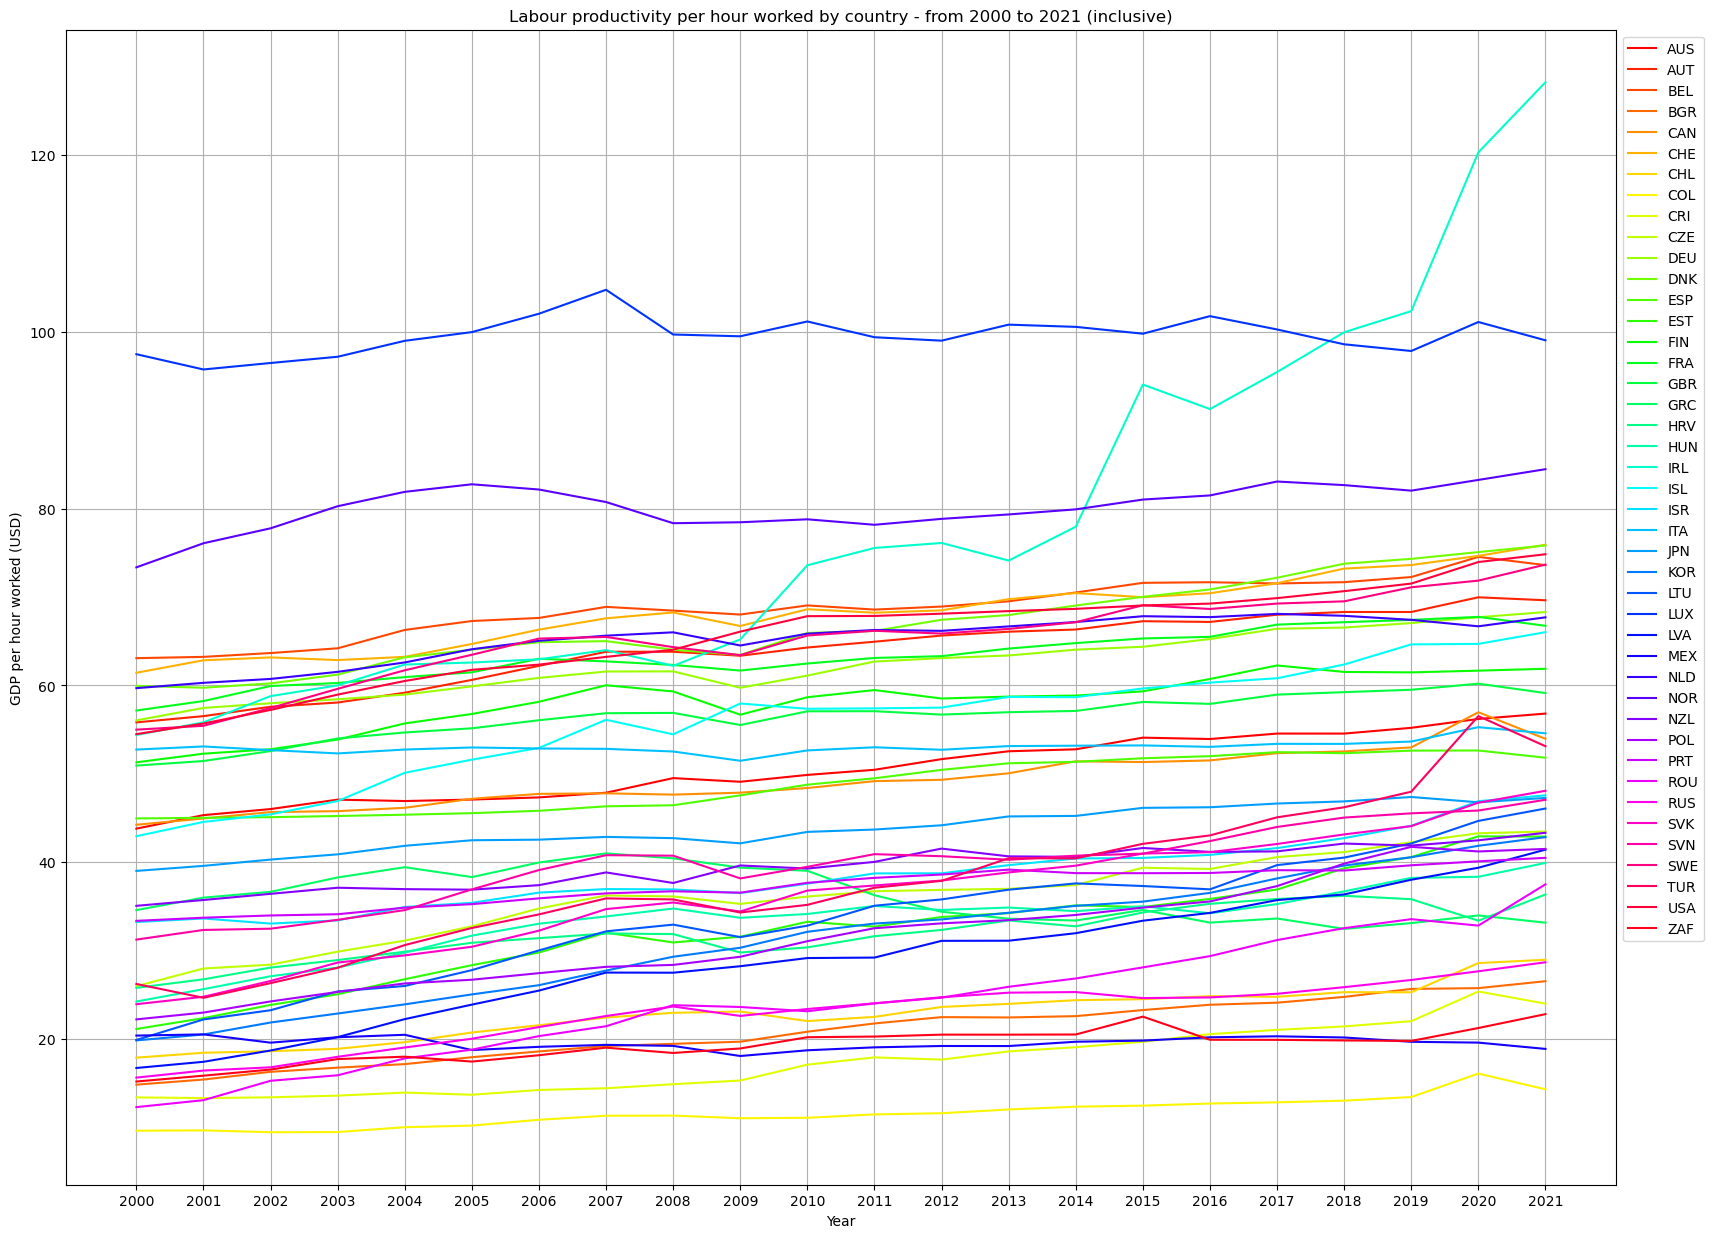

In [9]:
# plots every country's labour productivity throughout time

plt.figure(figsize=(20, 15))

colors = plt.cm.hsv(np.linspace(0, 1, numberOfRows))

for row in range(numberOfRows):
    countryCode = cleanedData.iloc[row][0]
    plt.plot(np.array(cleanedData.columns[1:]), cleanedData.iloc[row][1:], color=colors[row], label=countryCode)

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel('Year') 
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by country - from 2000 to 2021 (inclusive)")

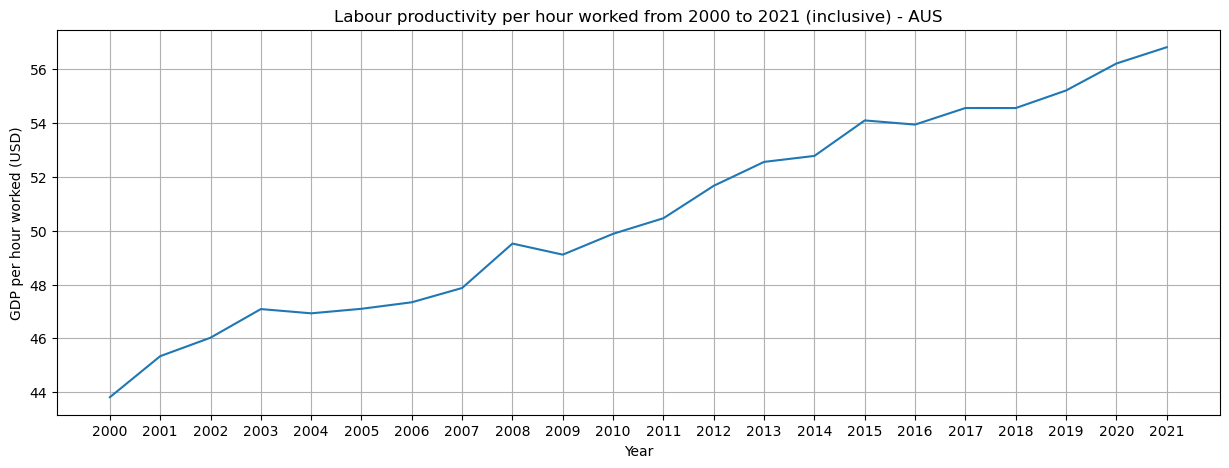

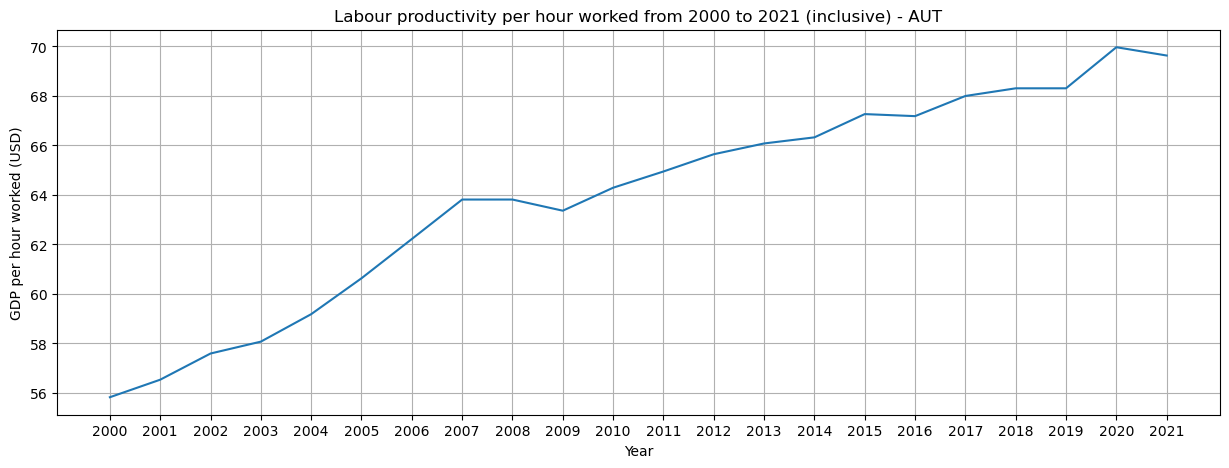

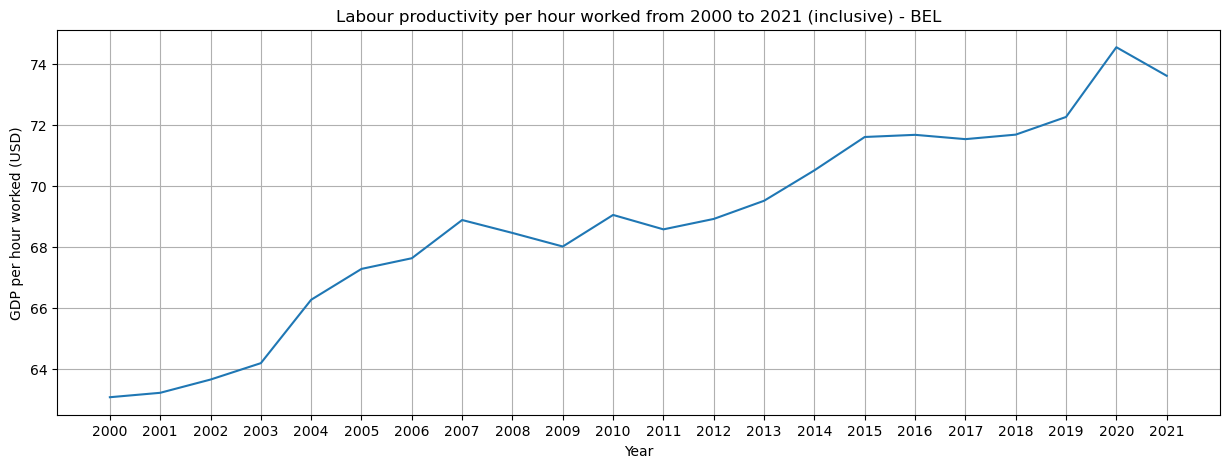

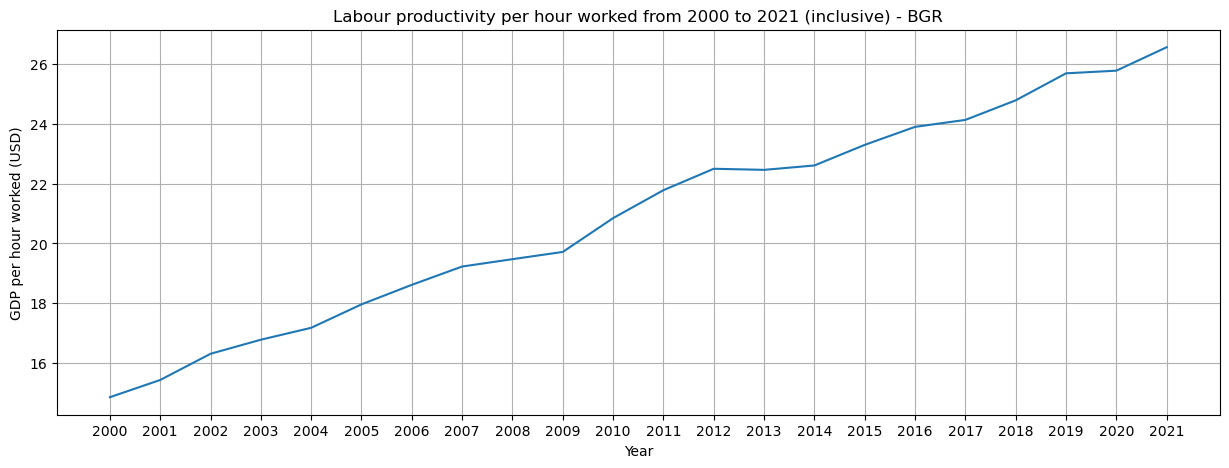

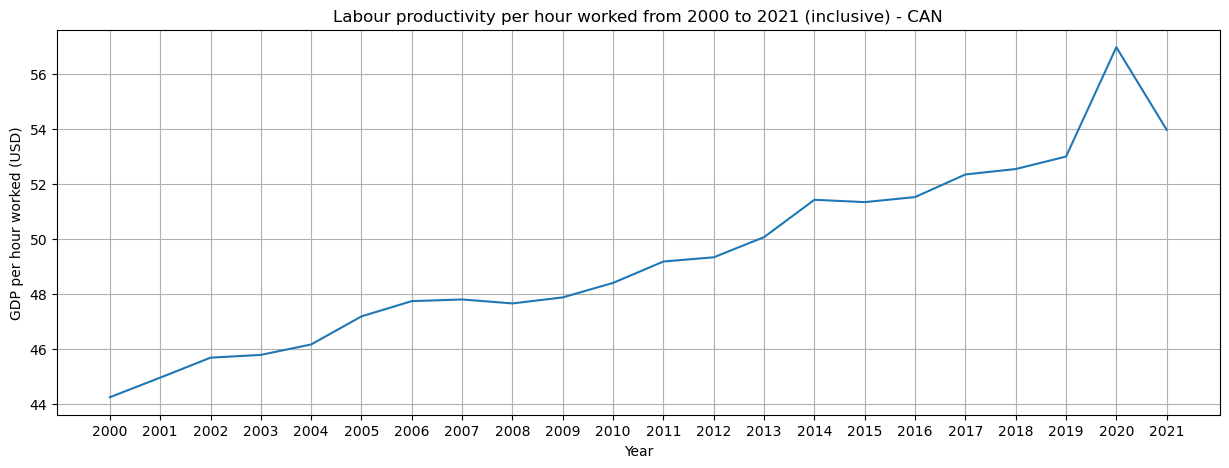

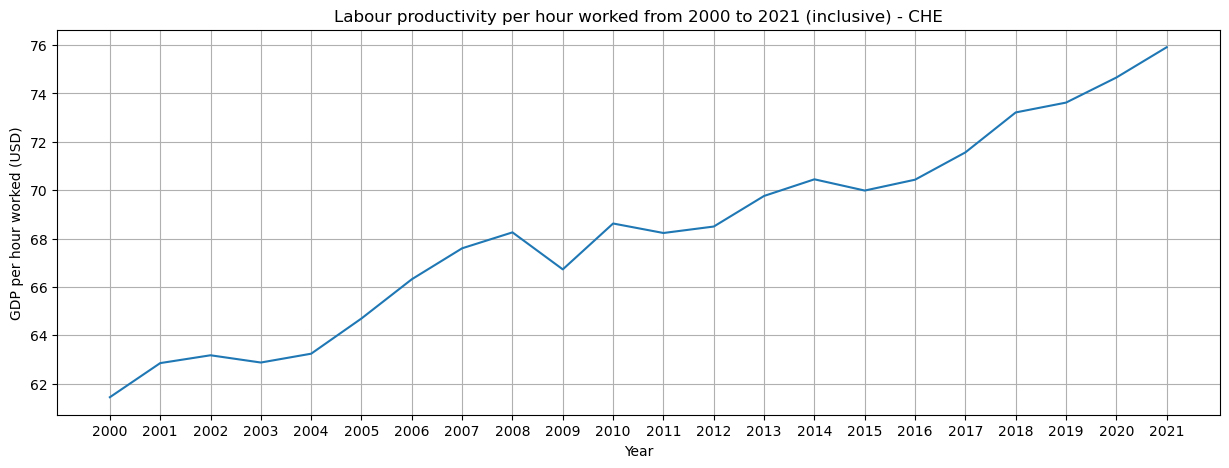

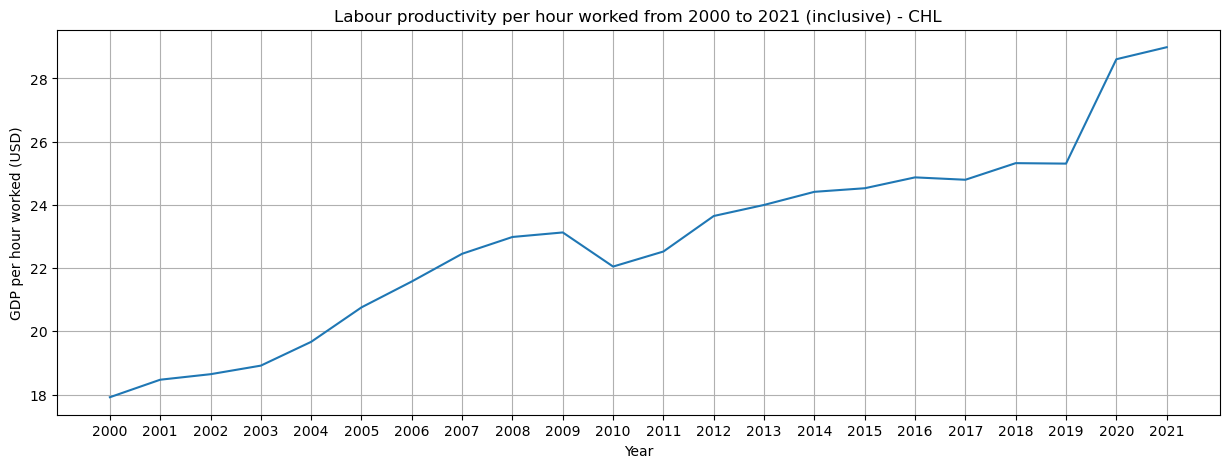

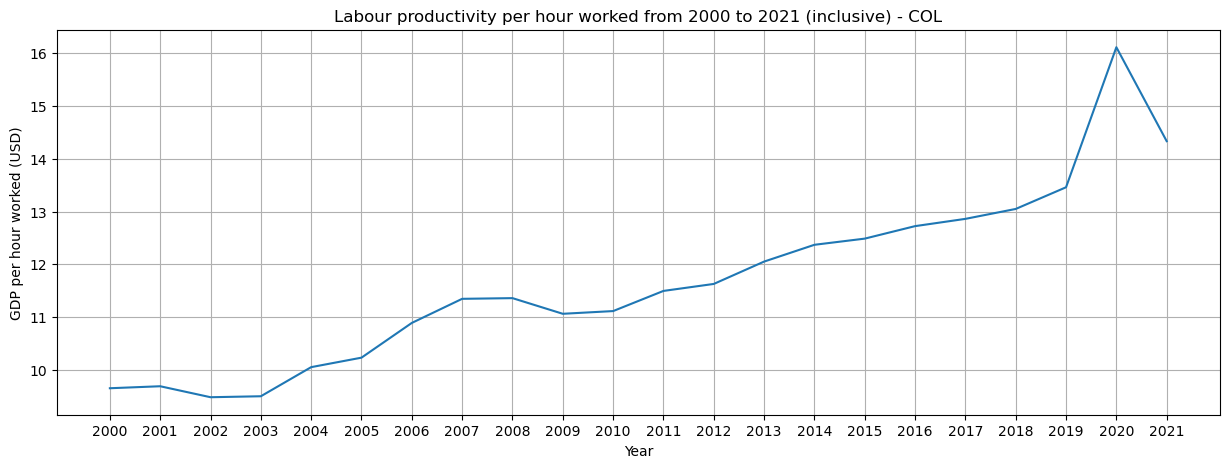

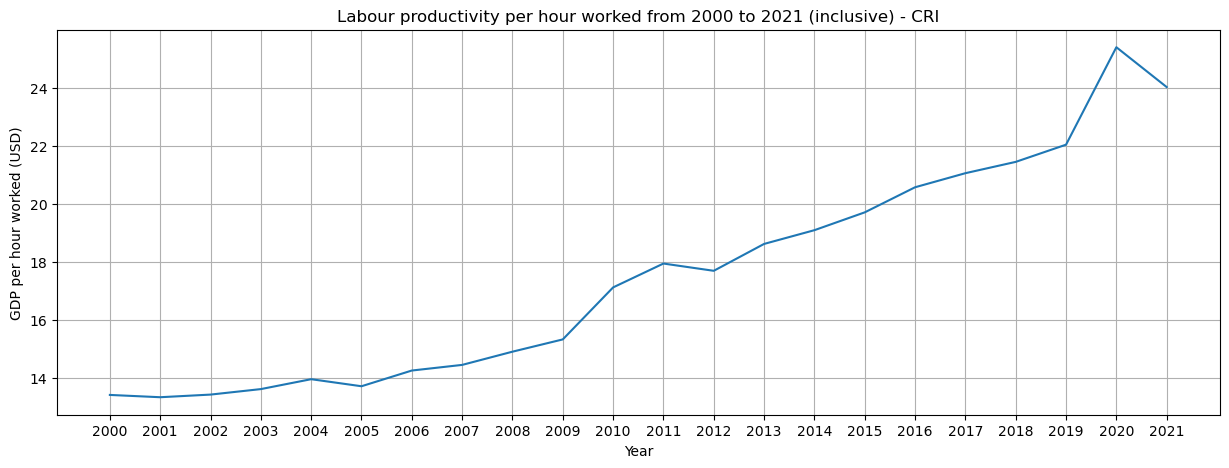

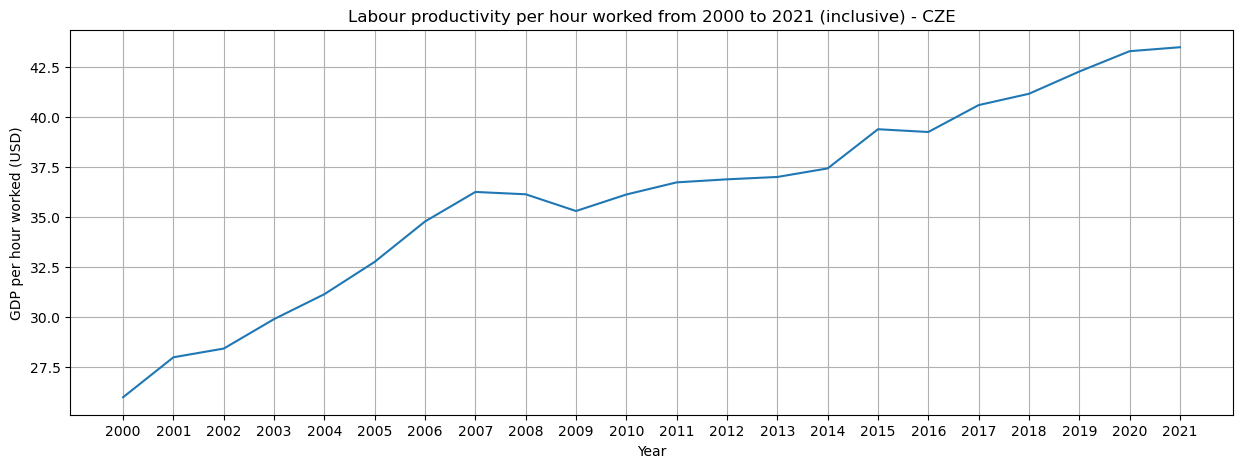

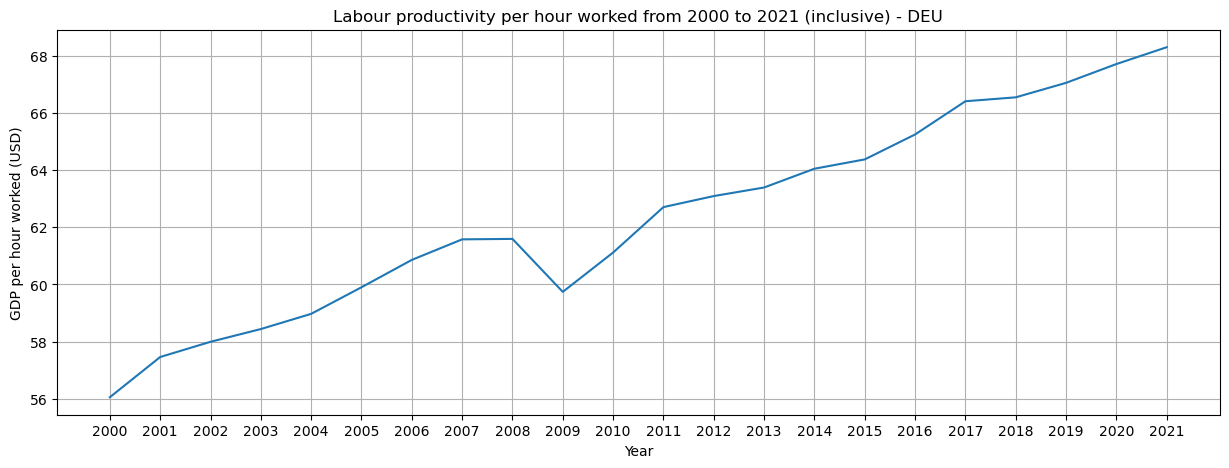

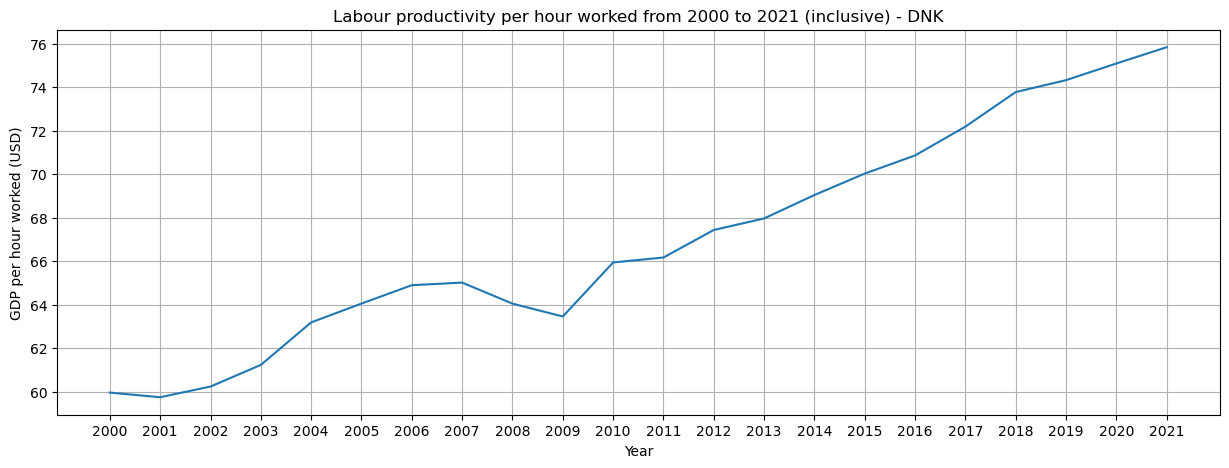

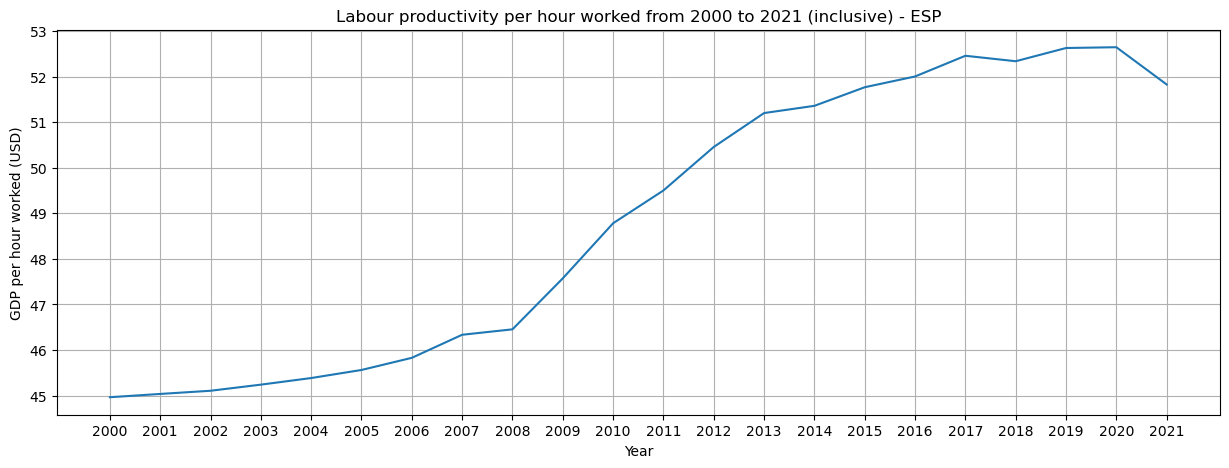

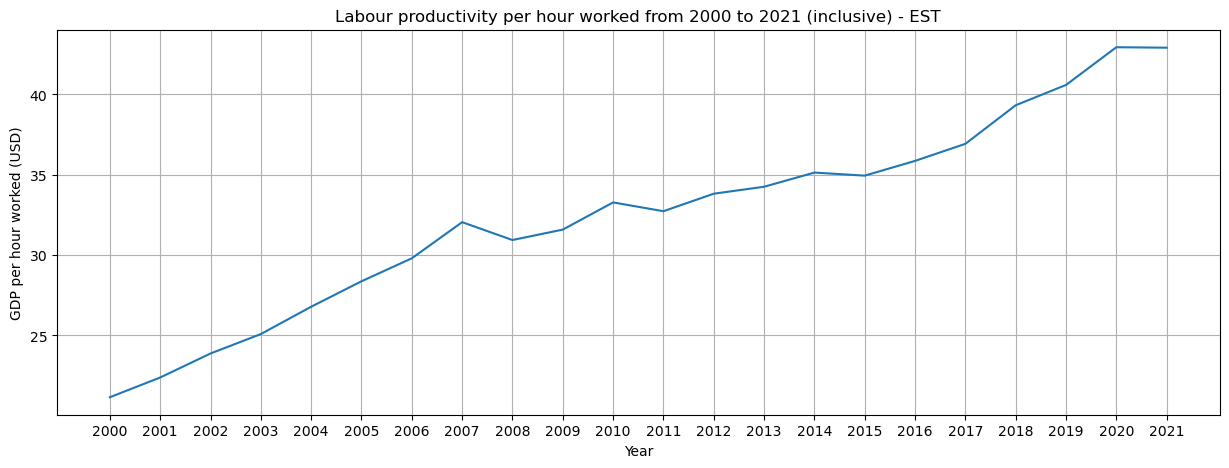

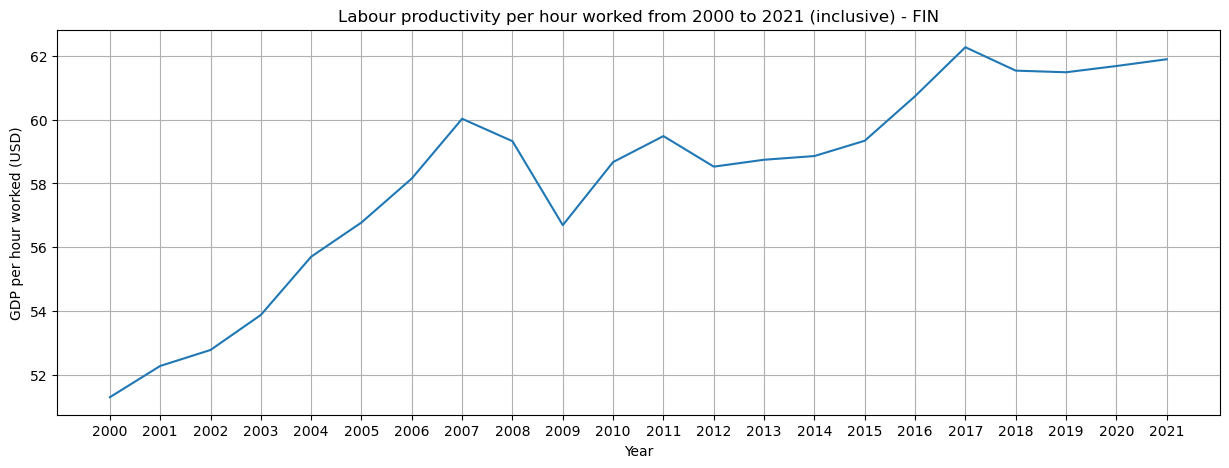

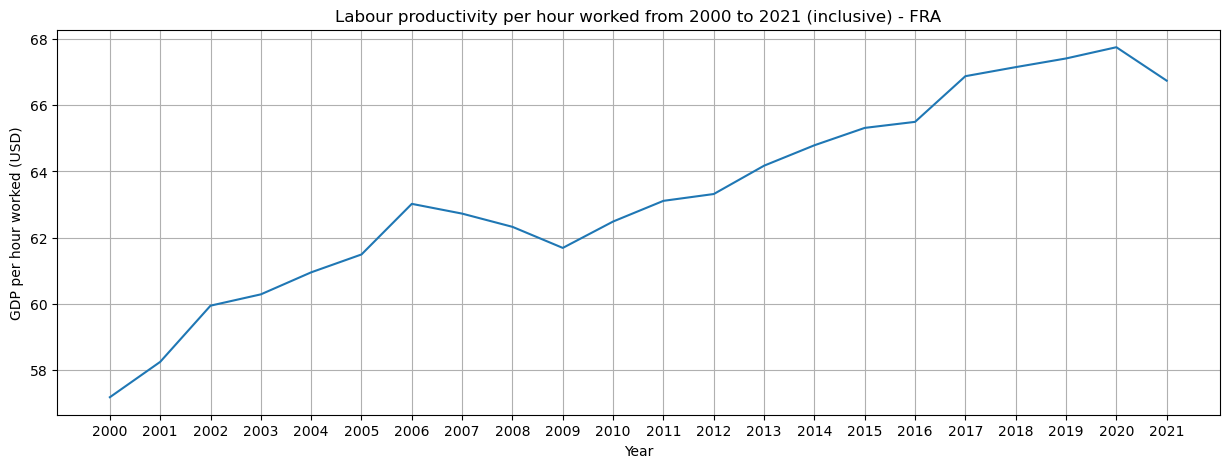

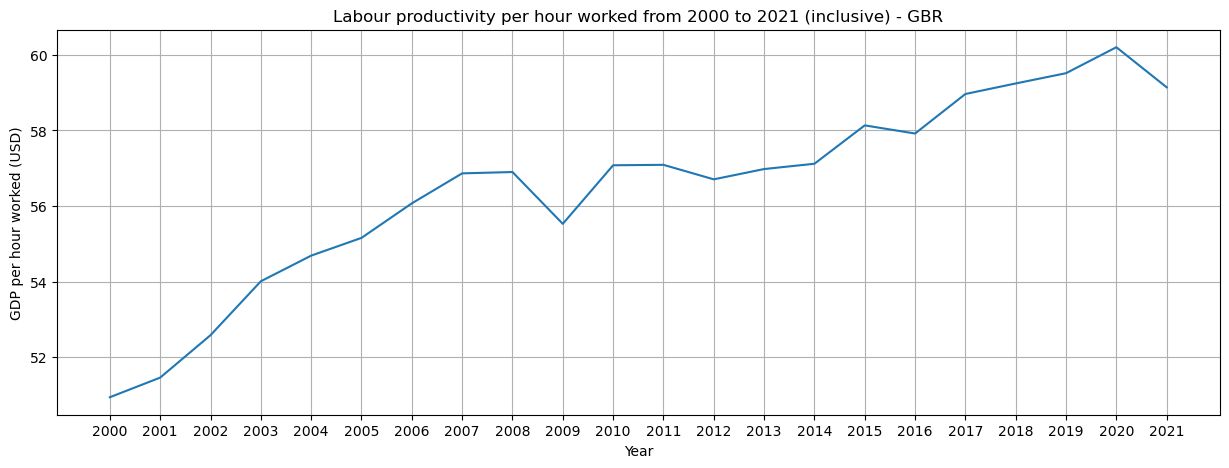

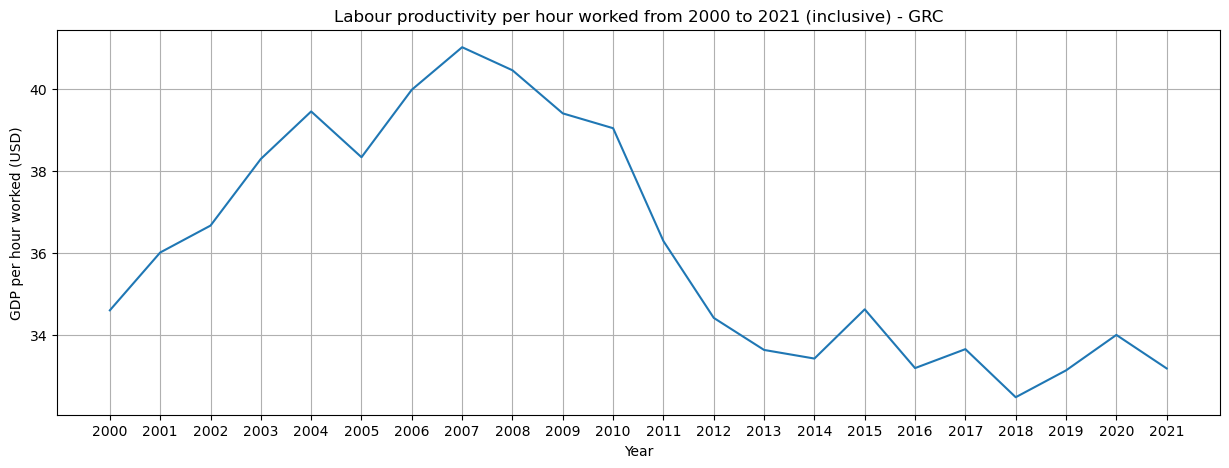

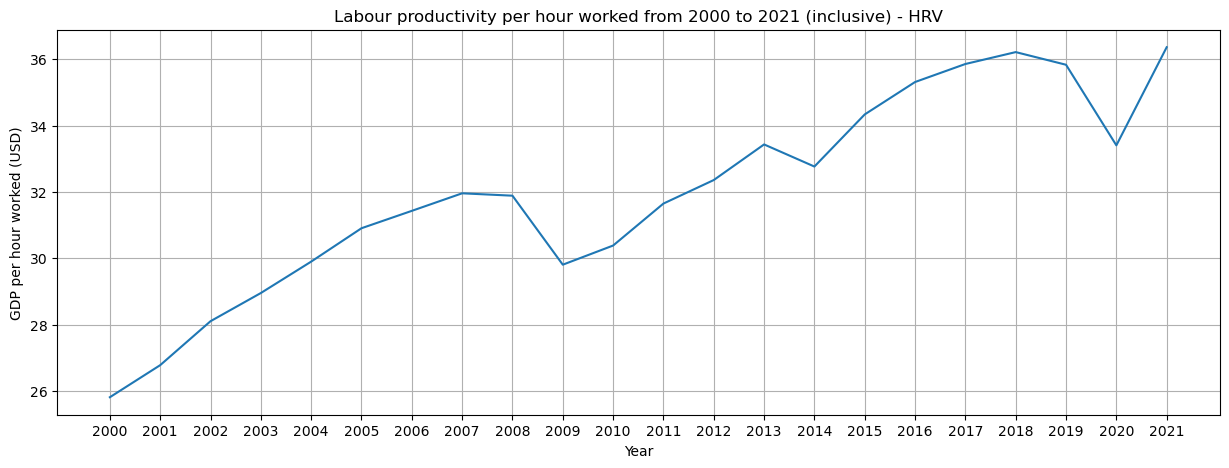

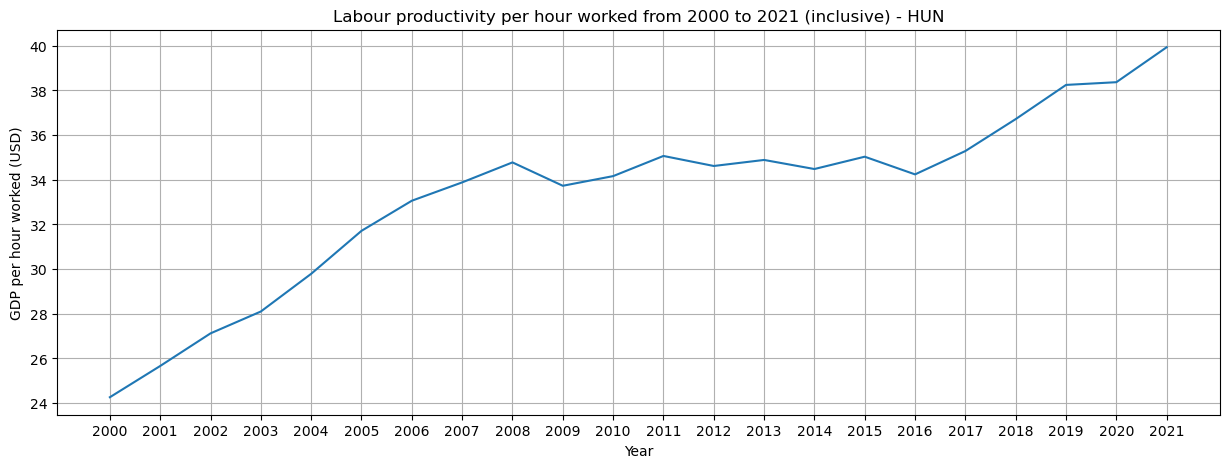

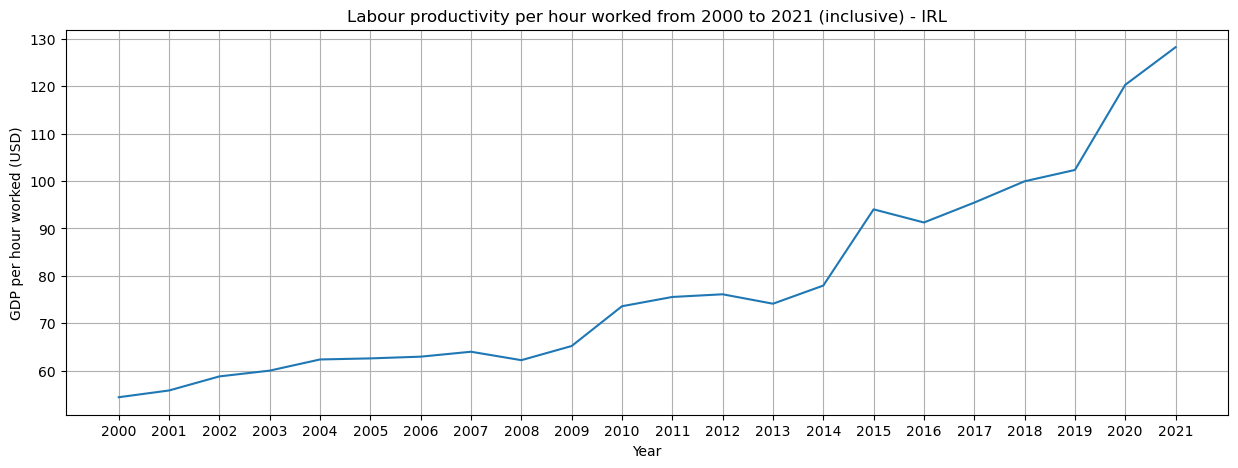

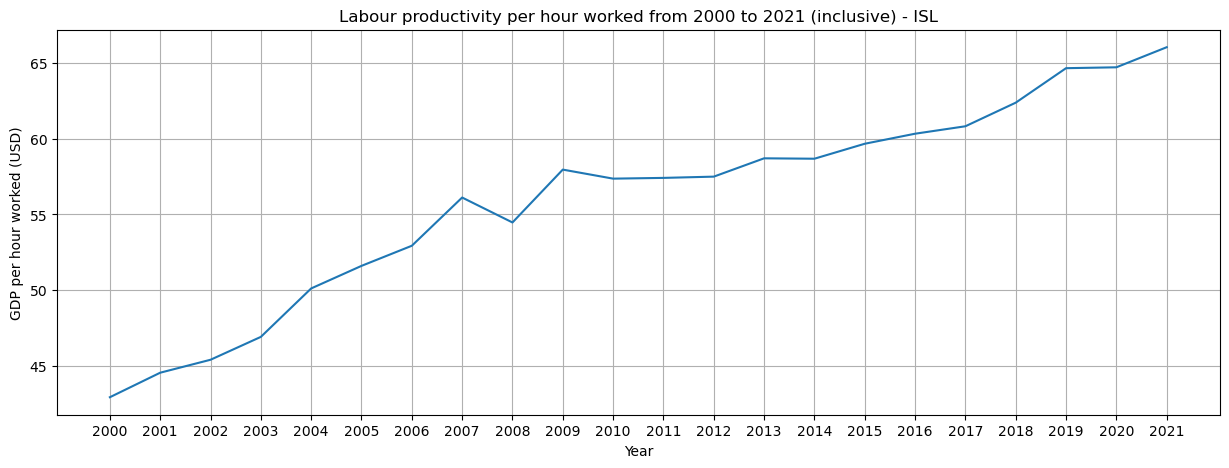

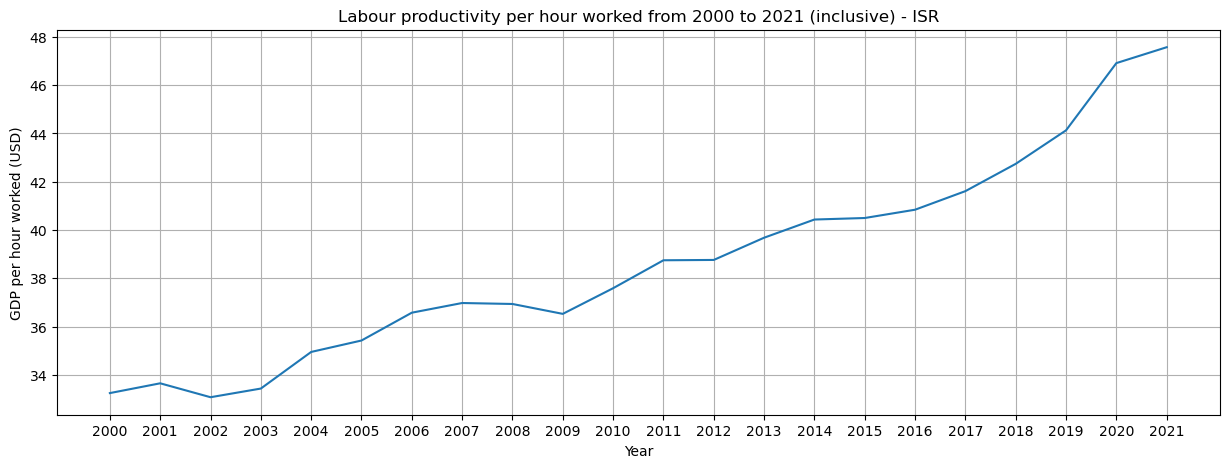

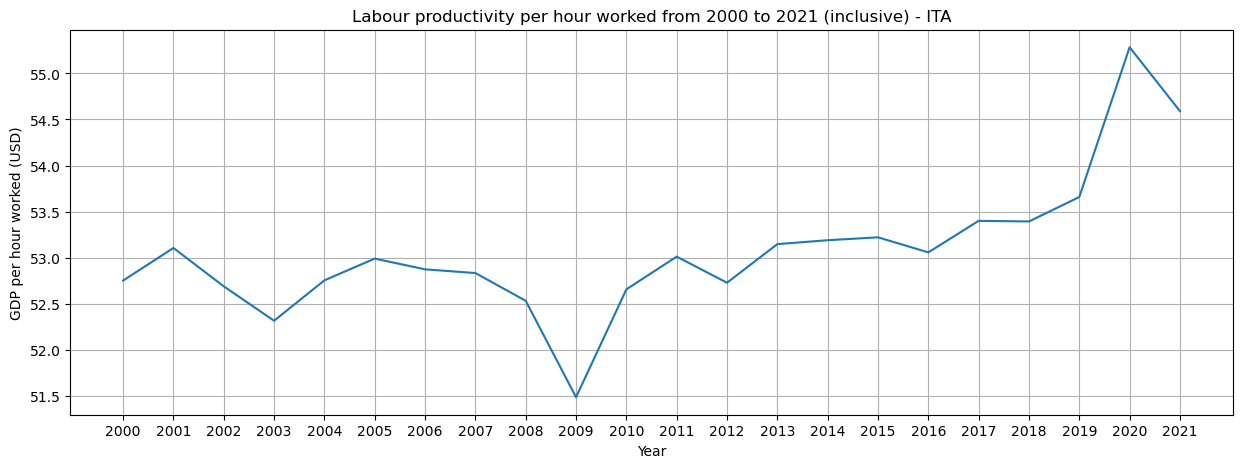

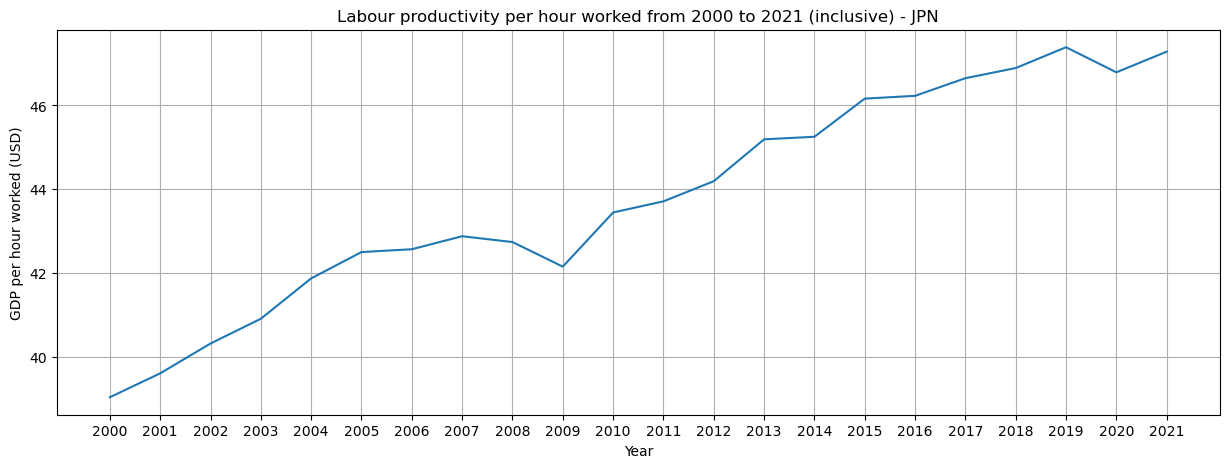

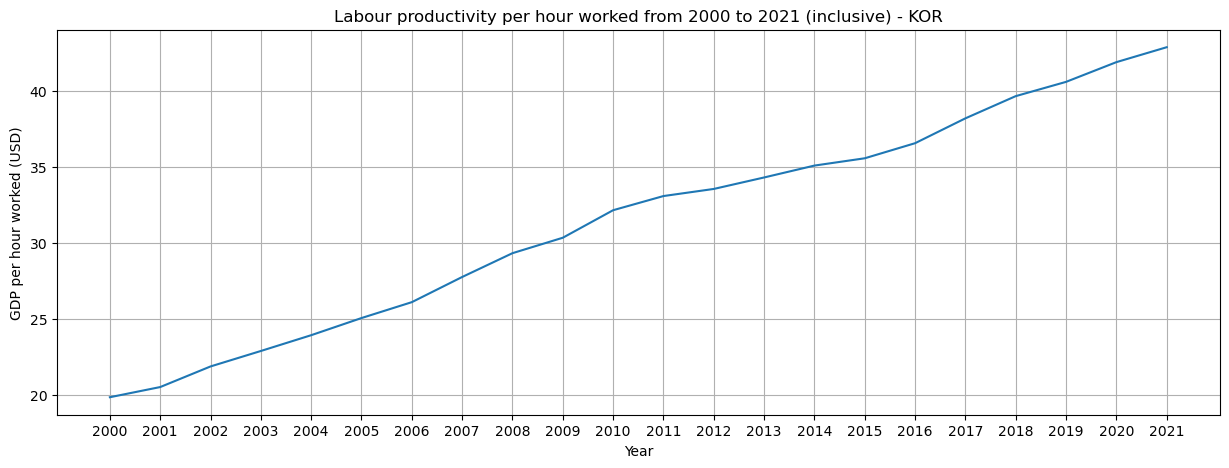

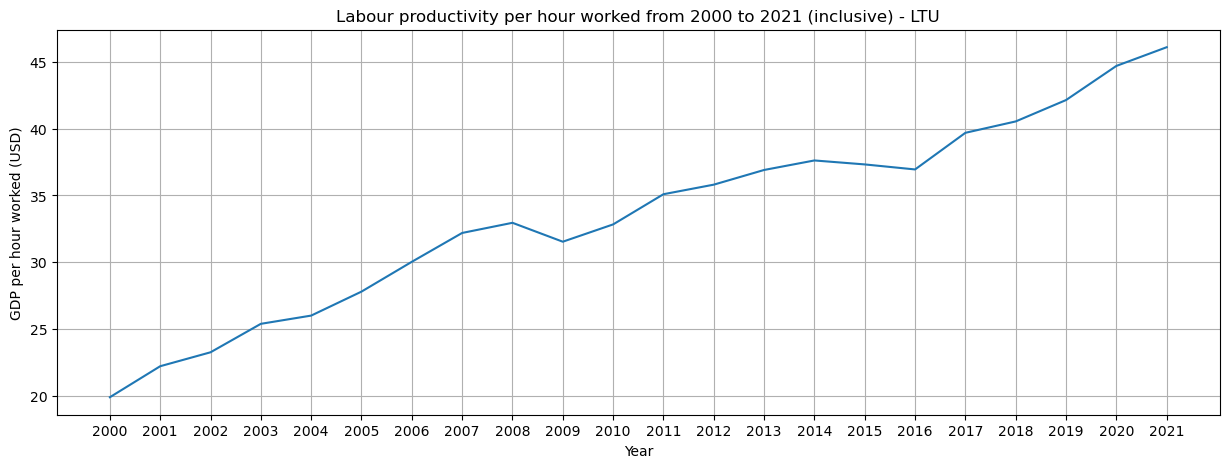

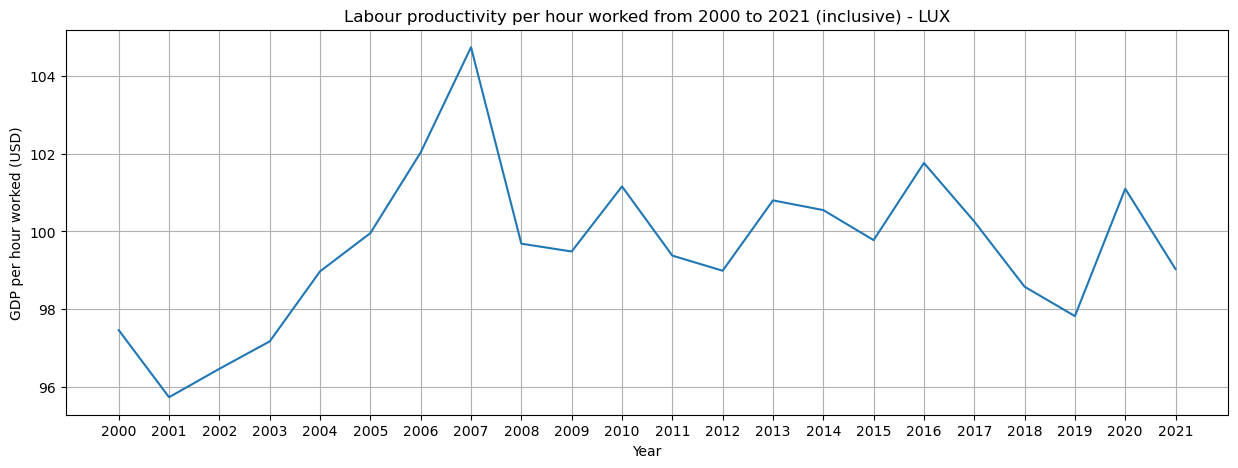

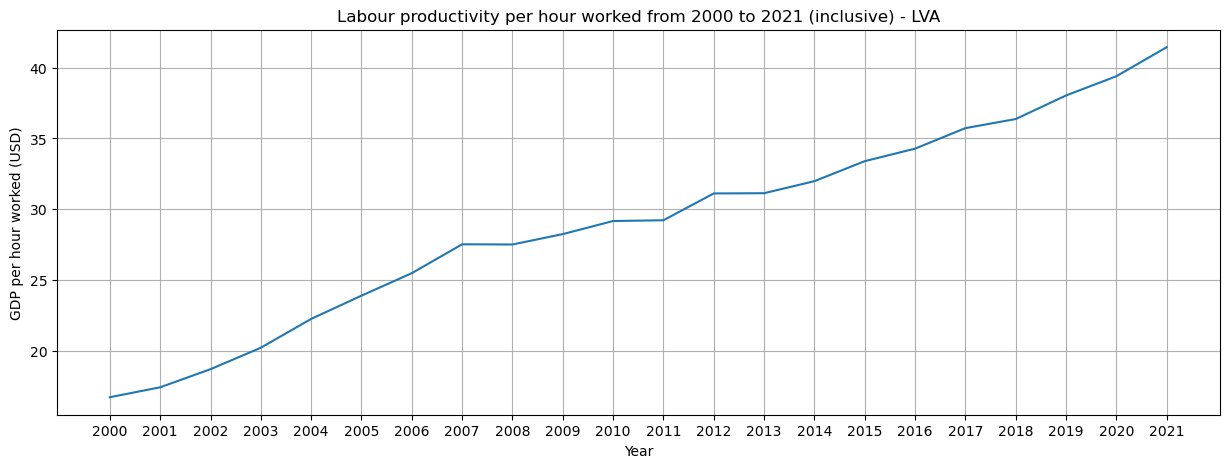

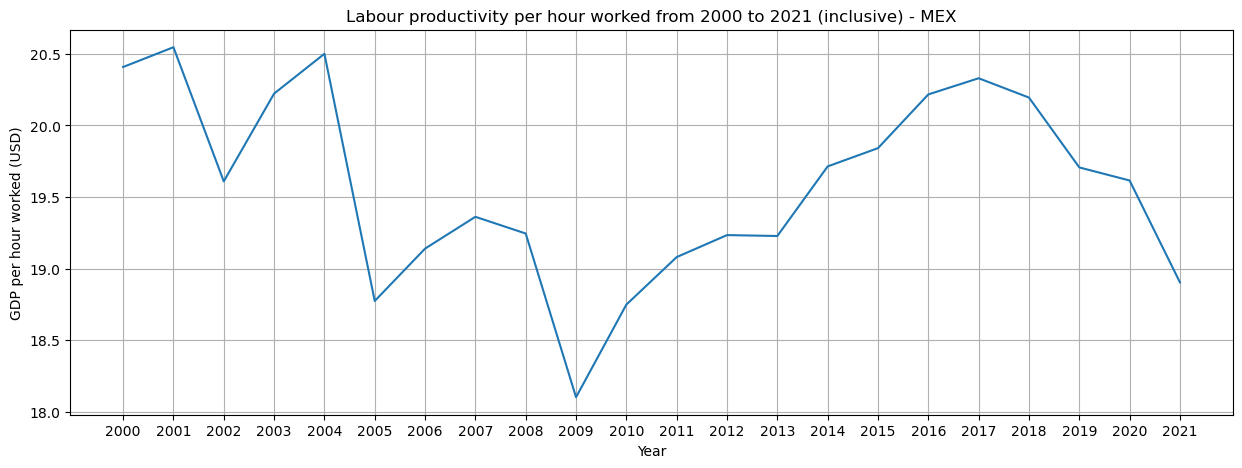

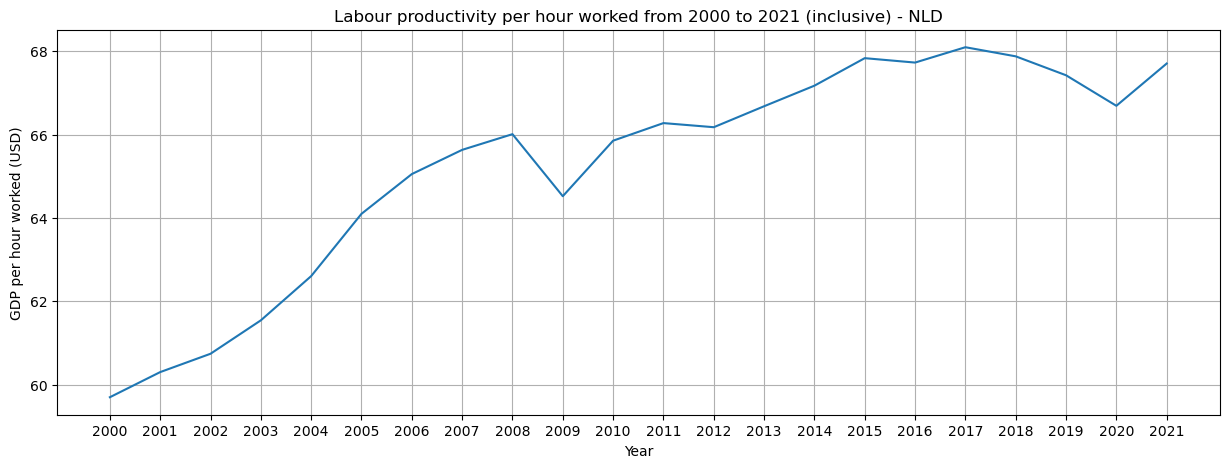

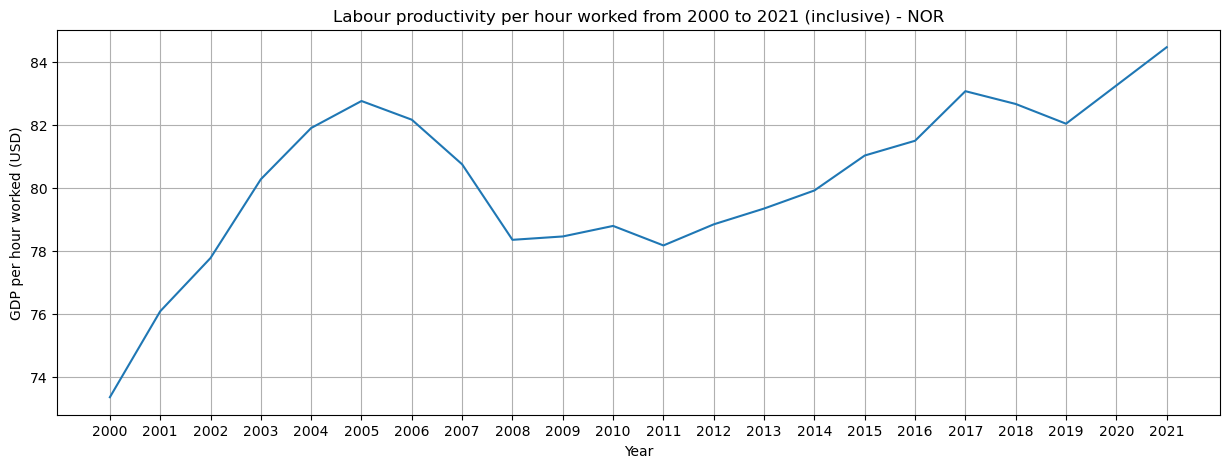

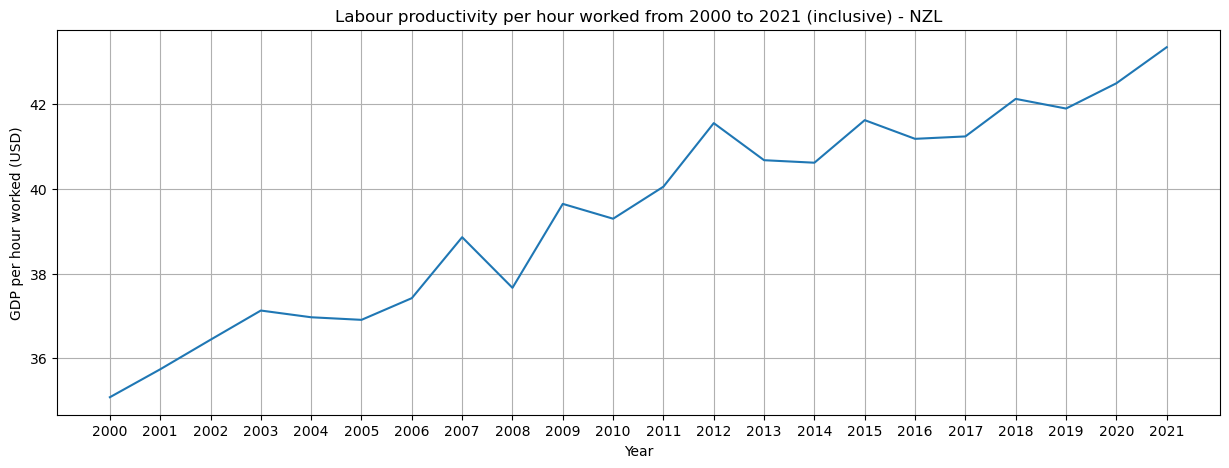

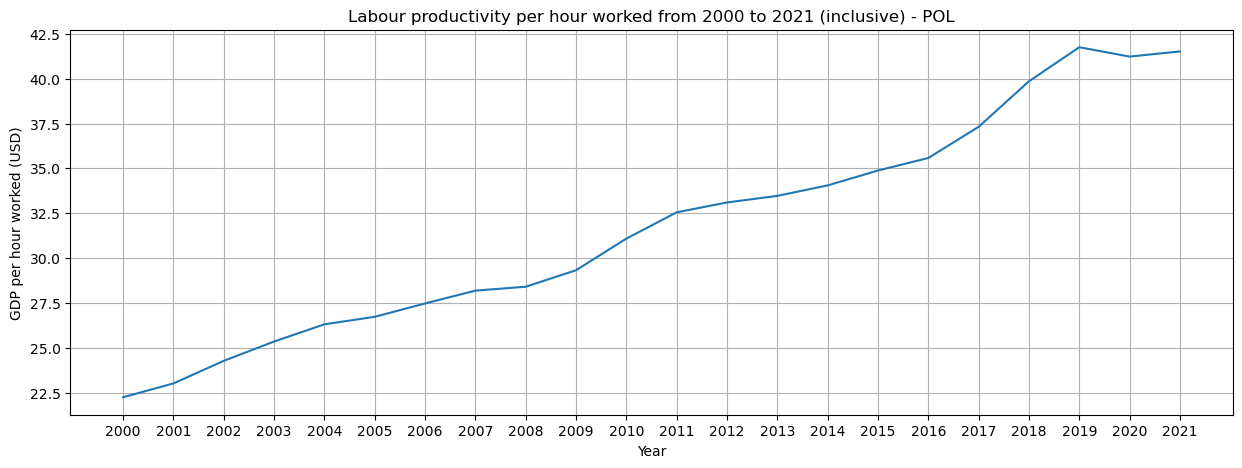

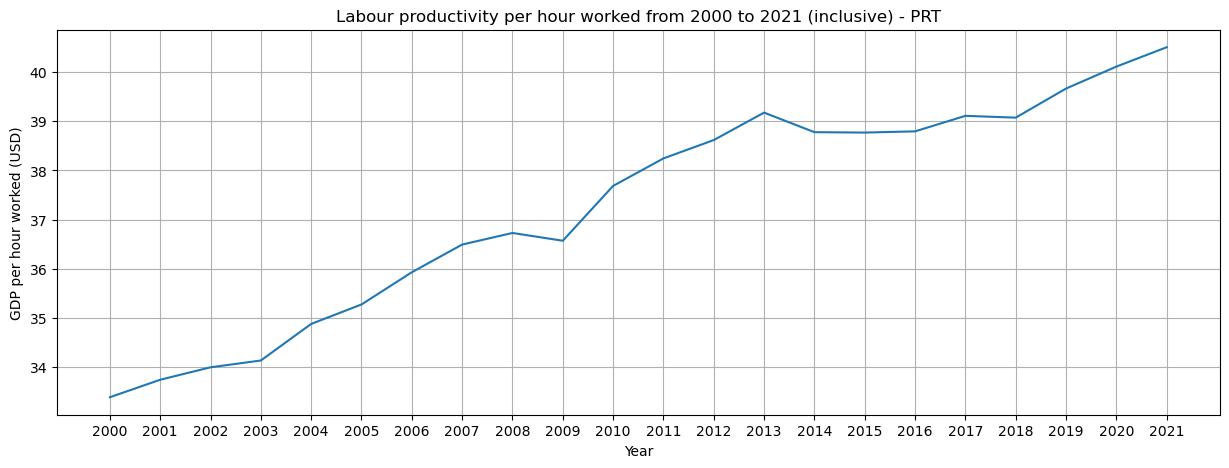

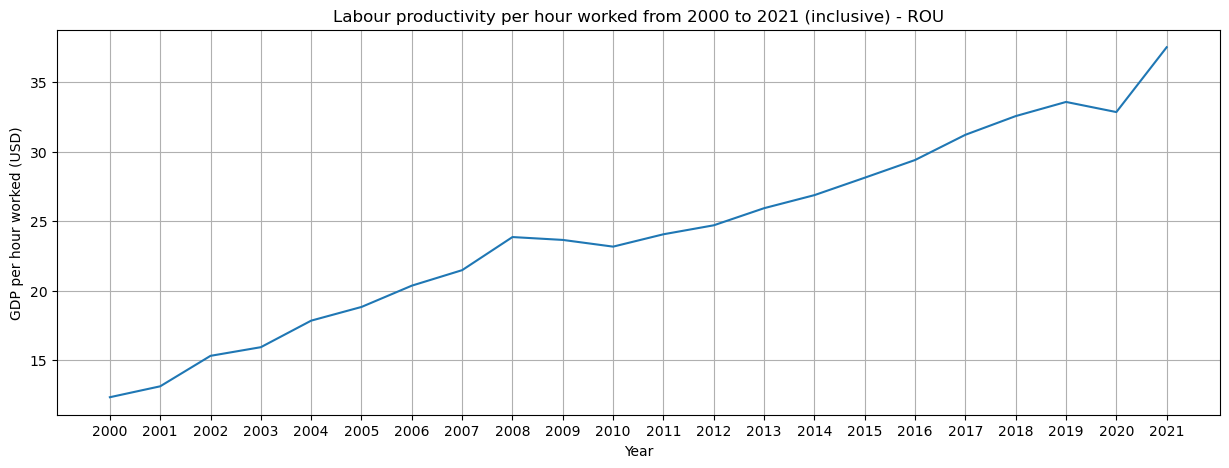

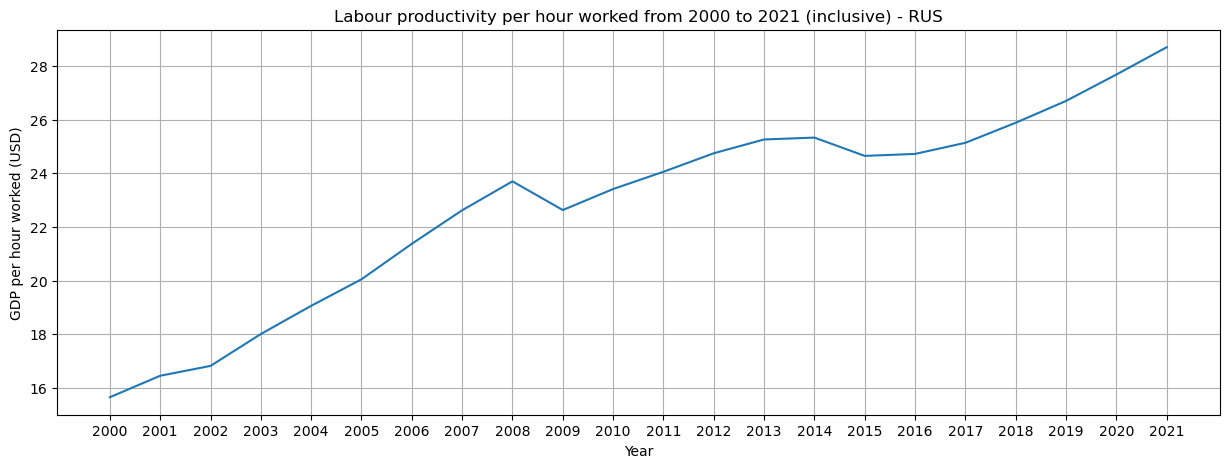

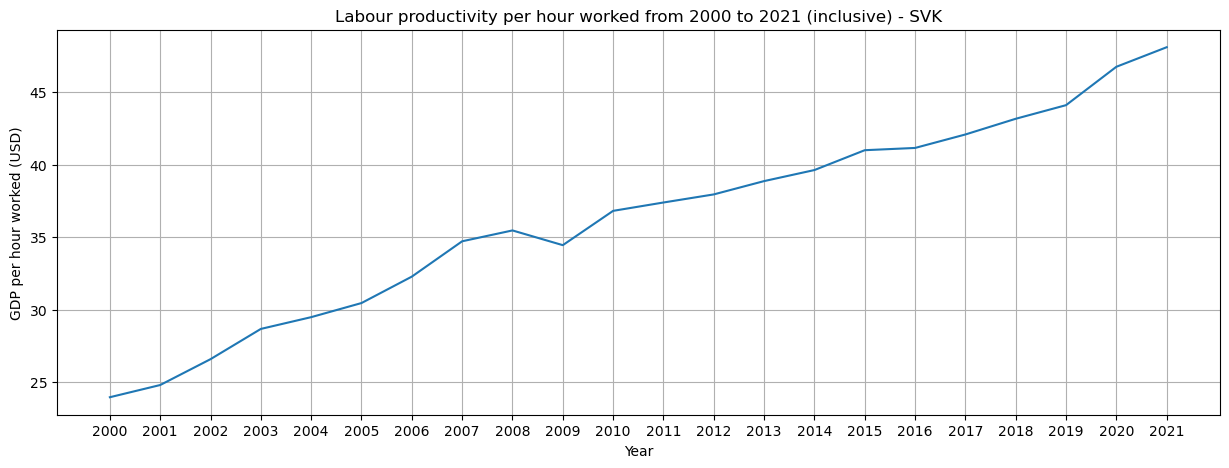

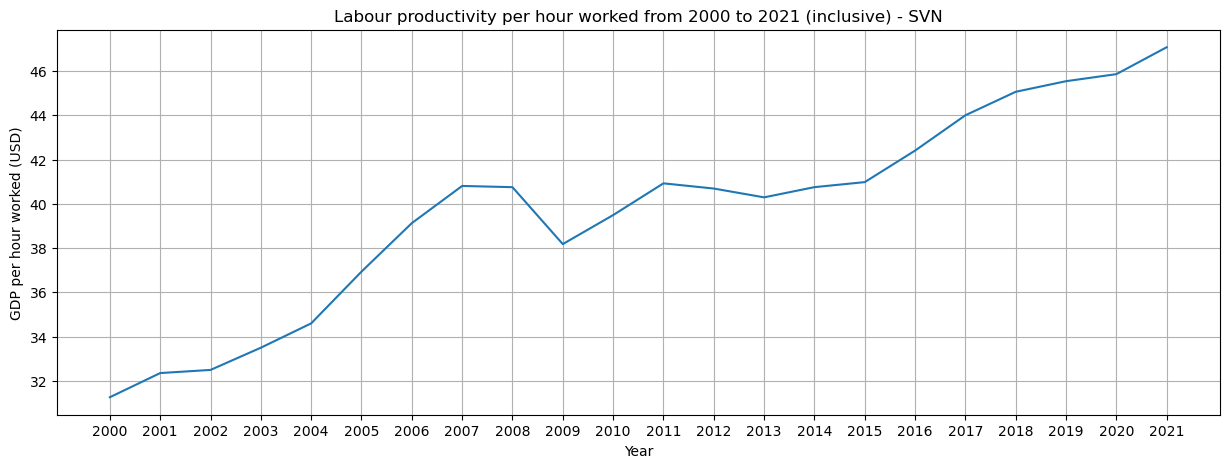

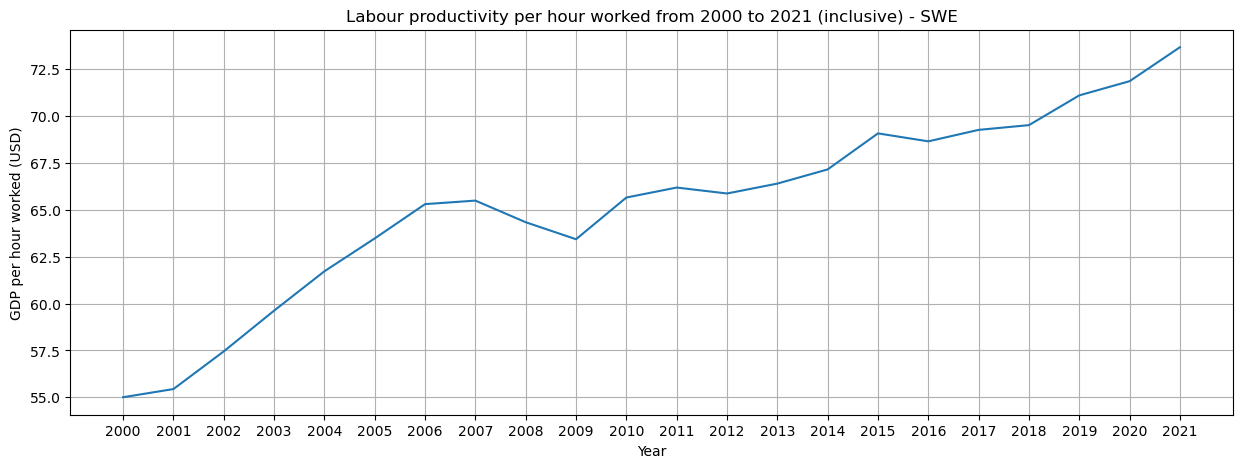

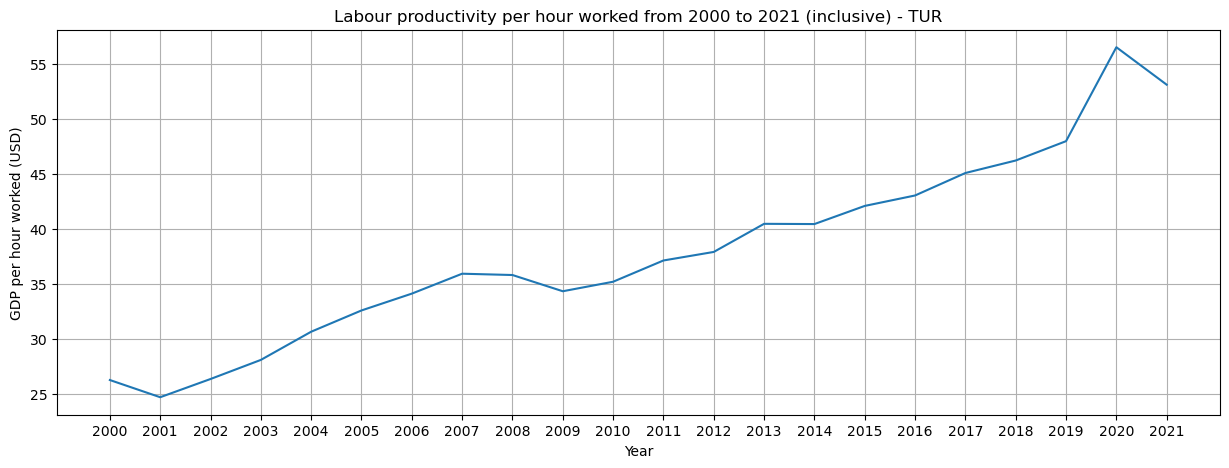

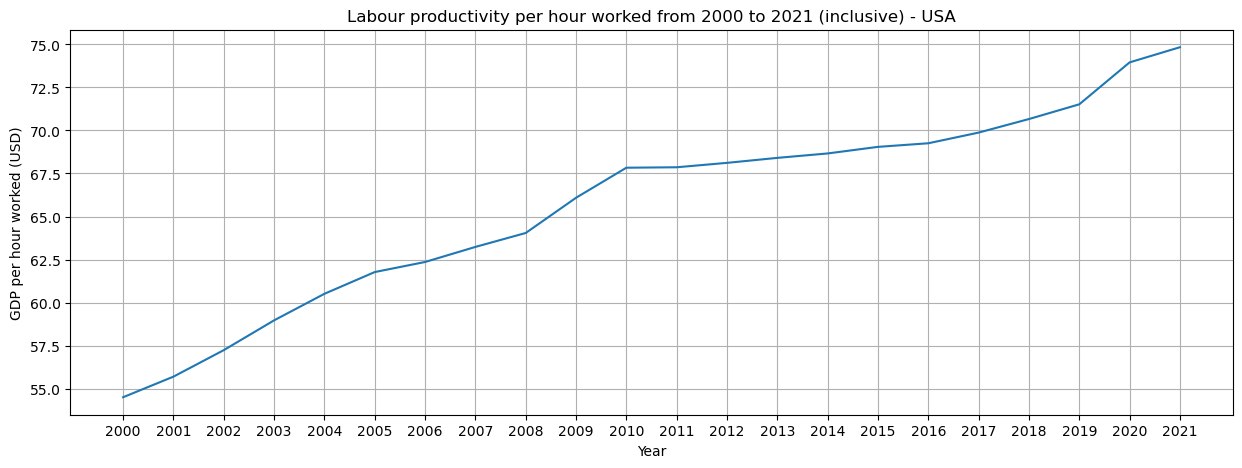

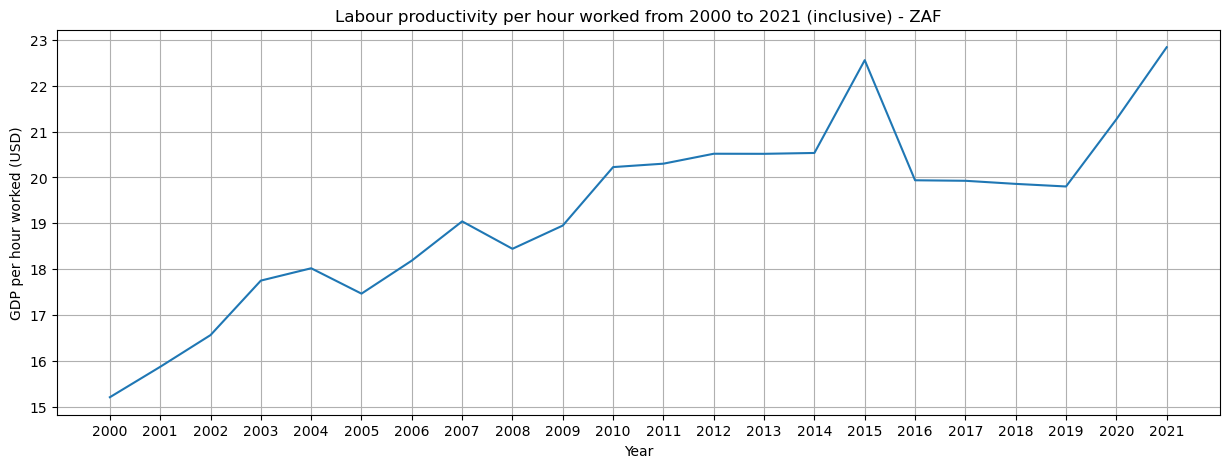

In [10]:
# plots each individual country's labour productivity throughout time

for row in range(numberOfRows):
    plt.figure(figsize=(15, 5))
    countryCode = cleanedData.iloc[row][0]
    plt.plot(np.array(cleanedData.columns[1:]), cleanedData.iloc[row][1:])

    plt.grid()
    plt.xlabel('Year') 
    plt.ylabel('GDP per hour worked (USD)')
    plt.title("Labour productivity per hour worked from 2000 to 2021 (inclusive) - " + countryCode)

    plt.show()

In [11]:
# adds a column to the data containing every country's mean labour productivity

countryCodesPHW = []
countryMeansPHW = []

for row in range(numberOfRows):
    countryCode = cleanedData.iloc[row][0]
    countryCodesPHW.append(countryCode)
    countryMeansPHW.append(round(float(np.mean(cleanedData.iloc[row][1:])), 6))

cleanedData['mean'] = countryMeansPHW

/var/folders/jv/flhd9_611gvdf13cfv1w9t640000gn/T/ipykernel_3337/1960724260.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(countryCodesPHW[countryMeansPHW.index(sortedcountryMeansPHW[row])], sortedcountryMeansPHW[row], c=colors[row])


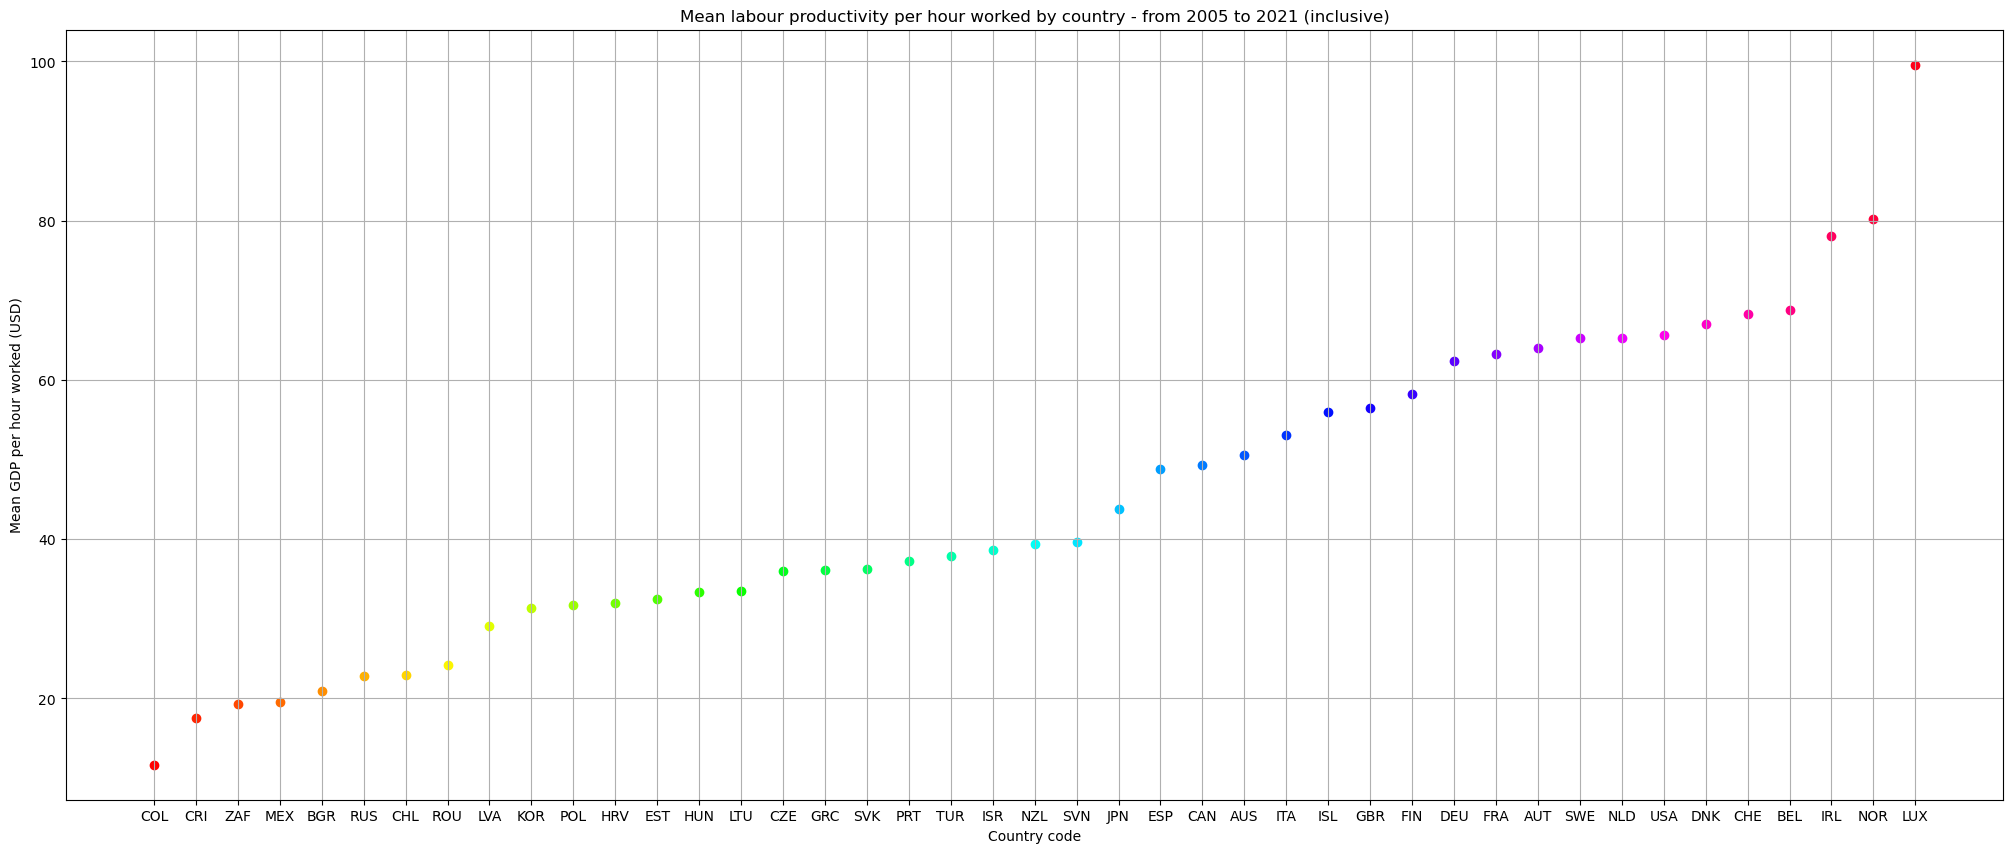

In [12]:
# plots every country's mean labour productivity (in increasing order)

plt.figure(figsize=(25, 10))

sortedcountryMeansPHW = np.sort(countryMeansPHW)

for row in range(numberOfRows):
    plt.scatter(countryCodesPHW[countryMeansPHW.index(sortedcountryMeansPHW[row])], sortedcountryMeansPHW[row], c=colors[row])

plt.grid()
plt.xlabel('Country code') 
plt.ylabel('Mean GDP per hour worked (USD)')
plt.title("Mean labour productivity per hour worked by country - from 2000 to 2021 (inclusive)")

plt.show()

In [13]:
Australia = 'AUS'
Austria = 'AUT'
Belgium = 'BEL'
Bulgaria = 'BGR'
Canada = 'CAN'
Switzerland = 'CHE'
Chile = 'CHL'
Colombia = 'COL'
CostaRica = 'CRI'
CzechRepublic = 'CZE'
Germany = 'DEU'
Denmark = 'DNK'
Spain = 'ESP'
Estonia = 'EST'
Finland = 'FIN'
France = 'FRA'
UnitedKingdom = 'GBR'
Greece = 'GRC'
Croatia = 'HRV'
Hungary = 'HUN'
Ireland = 'IRL'
Iceland = 'ISL'
Israel = 'ISR'
Italy = 'ITA'
Japan = 'JPN'
Korea = 'KOR'
Lithuania = 'LTU'
Luxembourg = 'LUX'
Latvia = 'LVA'
Mexico = 'MEX'
Netherlands = 'NLD'
Norway = 'NOR'
NewZealand = 'NZL'
Poland = 'POL'
Portugal = 'PRT'
Romania = 'ROU'
Russia = 'RUS'
Slovakia = 'SVK'
Slovenia = 'SVN'
Sweden = 'SWE'
Turkey = 'TUR'
UnitedStates = 'USA'
SouthAfrica = 'ZAF'

# accordignly to https://www.cia.gov/the-world-factbook/field/location/

CentralEurope = [Austria, CzechRepublic, Germany, Hungary, Poland, Slovakia, Slovenia, Switzerland]
EasternEurope = [Estonia, Latvia, Lithuania]
NorthernEurope = [Denmark, Finland, Norway, Sweden, Iceland]
SouthEasternEurope = [Bulgaria, Croatia, Romania, Turkey]
SouthernEurope = [Greece, Italy]
SouthWesternEurope = [Portugal, Spain]
WesternEurope = [Belgium, France, Ireland, Luxembourg, Netherlands, UnitedKingdom]

Europe = [CentralEurope, EasternEurope, NorthernEurope, SouthEasternEurope, SouthernEurope, SouthWesternEurope, WesternEurope]
EuropeFlat =  [country for subregion in Europe for country in subregion]

NorthAmerica = [Mexico, UnitedStates, Canada, CostaRica]
SouthAmerica = [Chile, Colombia]
Africa = [SouthAfrica]
Oceania = [Australia, NewZealand]
Asia = [Japan, Korea, Russia, Israel]

worldRegions = [EuropeFlat, NorthAmerica, SouthAmerica, Africa, Oceania, Asia]

"""print(len(CentralEurope)+len(EasternEurope)+len(NorthernEurope)+len(SouthEasternEurope)+len(SouthernEurope)+len(SouthWesternEurope)+len(WesternEurope)+
      len(Oceania)+len(NorthAmerica)+len(SouthAmerica)+len(Asia)+len(Africa))"""

'print(len(CentralEurope)+len(EasternEurope)+len(NorthernEurope)+len(SouthEasternEurope)+len(SouthernEurope)+len(SouthWesternEurope)+len(WesternEurope)+\n      len(Oceania)+len(NorthAmerica)+len(SouthAmerica)+len(Asia)+len(Africa))'

In [14]:
# computes the mean labour productivity of every European region and Europe itself

worldRegionMeans = []
europeMeans = []

for region in Europe:
    mean = 0
    count = 0

    for country in region:
        if country in countryCodesPHW:
            mean += float(cleanedData.loc[cleanedData['LOCATION'] == country]['mean'])
            count += 1

    mean = mean/count
    europeMeans.append(mean)

worldRegionMeans.append(np.mean(europeMeans))

In [15]:
# computes the mean labour productivity of the remaining continents (all but Europe)

NorthAmericaMeans = []
SouthAmericaMeans = []
AfricaMeans = []
OceaniaMeans = []
AsiaMeans = []
restOfTheWorldMeans = [NorthAmericaMeans, SouthAmericaMeans, AfricaMeans, OceaniaMeans, AsiaMeans]

for index, region in enumerate(worldRegions[1:]):
    mean = 0
    count = 0

    for country in region:
        if country in countryCodesPHW:
            countryMean = float(cleanedData.loc[cleanedData['LOCATION'] == country]['mean'])
            restOfTheWorldMeans[index].append(countryMean)
            mean += countryMean
            count += 1

    mean = mean/count
    worldRegionMeans.append(mean)

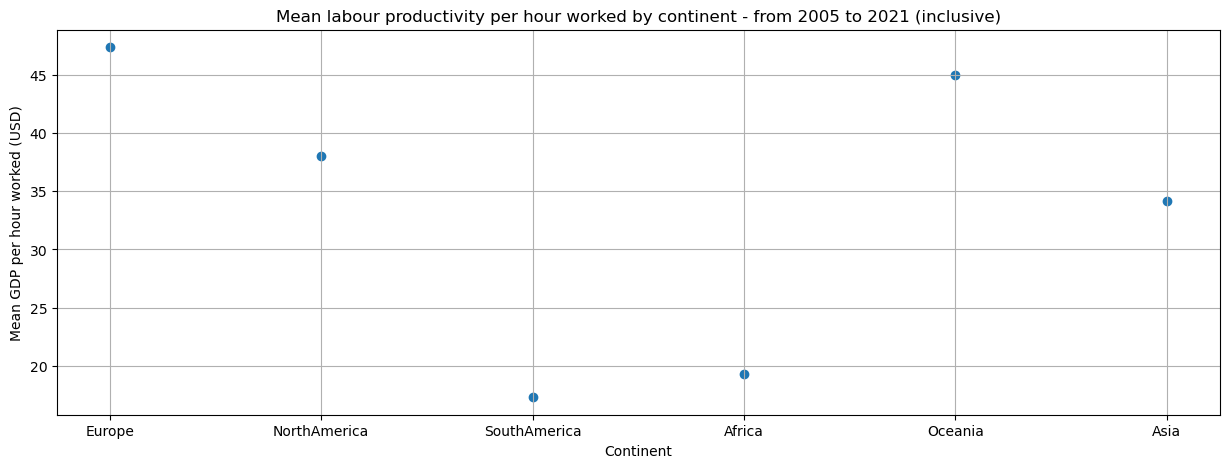

In [16]:
# plots the mean labour productivity of every continent

plt.figure(figsize=(15, 5))

plt.scatter(['Europe', 'NorthAmerica', 'SouthAmerica', 'Africa', 'Oceania', 'Asia'], worldRegionMeans)

plt.grid()
plt.xlabel('Continent') 
plt.ylabel('Mean GDP per hour worked (USD)')
plt.title("Mean labour productivity per hour worked by continent - from 2000 to 2021 (inclusive)")
plt.show()

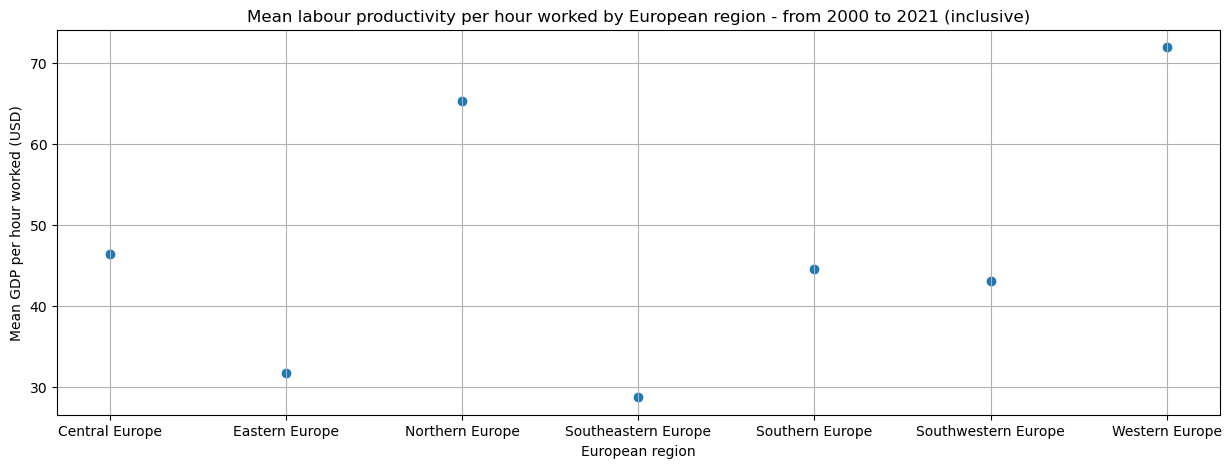

In [23]:
# plots the mean labour productivity of every European region

plt.figure(figsize=(15, 5))

plt.scatter(['Central Europe', 'Eastern Europe', 'Northern Europe', 'Southeastern Europe', 'Southern Europe', 'Southwestern Europe', 'Western Europe'], europeMeans)

plt.grid()
plt.xlabel('European region') 
plt.ylabel('Mean GDP per hour worked (USD)')
plt.title("Mean labour productivity per hour worked by European region - from 2000 to 2021 (inclusive)")
plt.show()

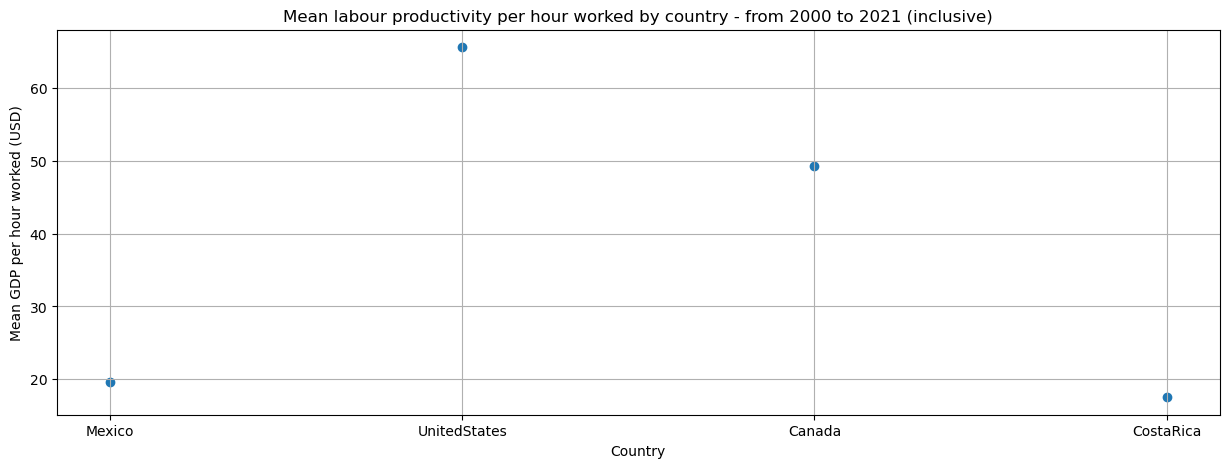

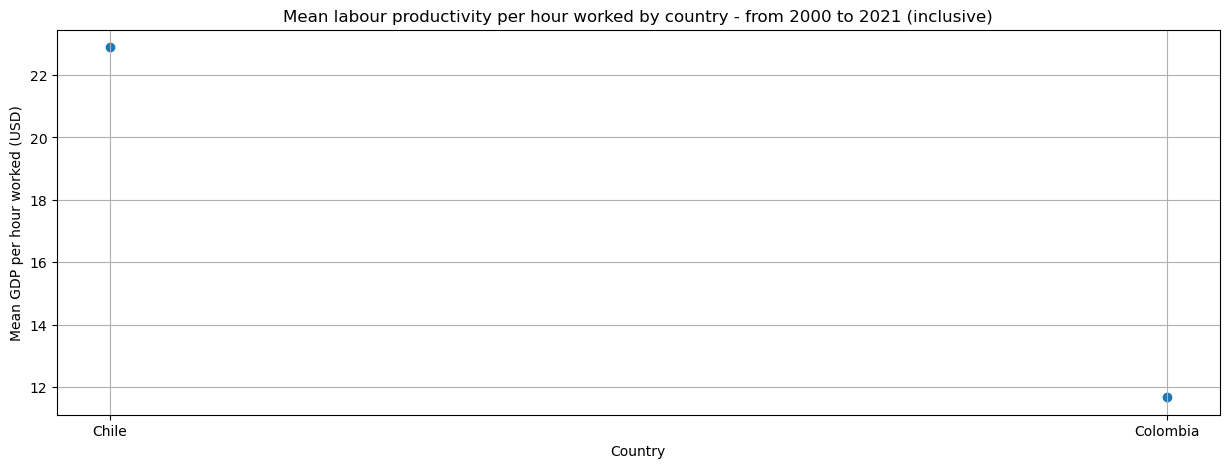

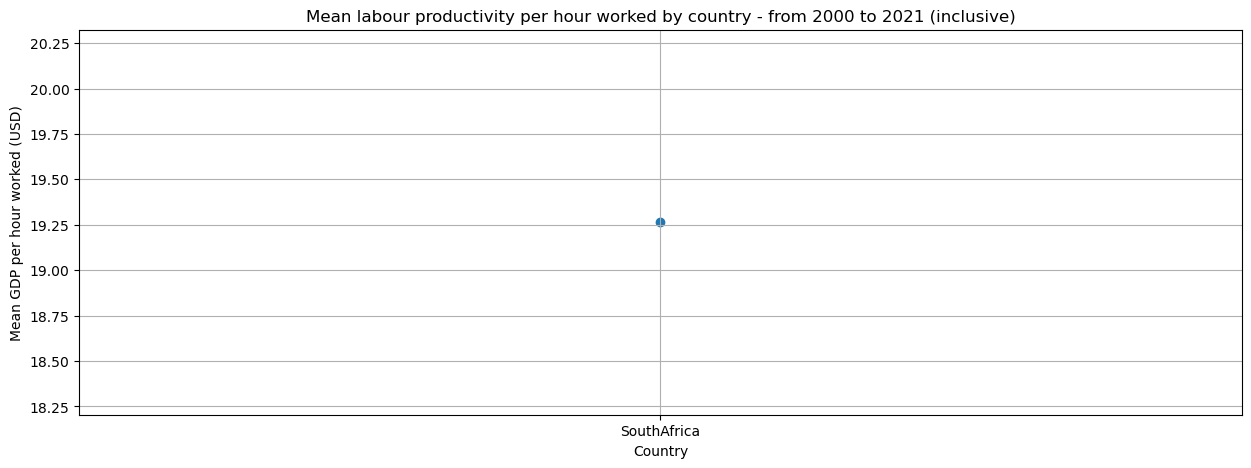

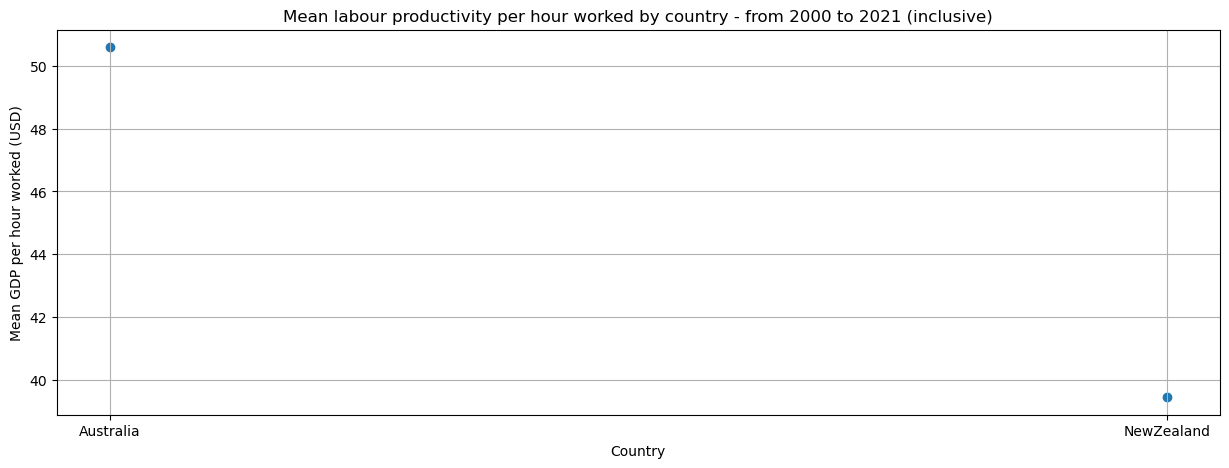

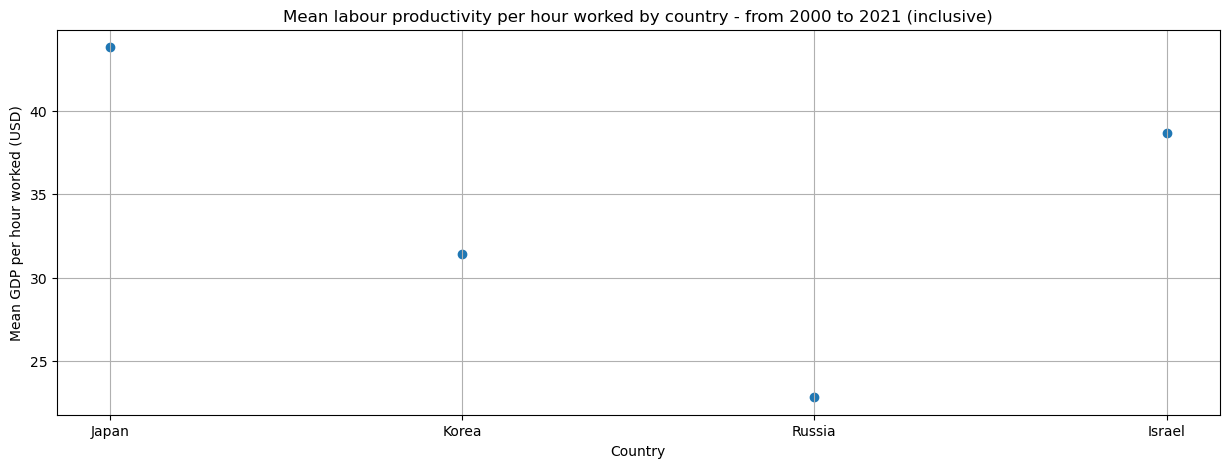

In [24]:
# plots the mean labour productivity of every country within each continent (all but Europe)

restOfTheWorldStrings = [['Mexico', 'UnitedStates', 'Canada', 'CostaRica'], ['Chile', 'Colombia'], ['SouthAfrica'], ['Australia', 'NewZealand'], ['Japan', 'Korea', 'Russia', 'Israel']]

for index, region in enumerate(restOfTheWorldStrings):
    plt.figure(figsize=(15, 5))

    plt.scatter(region, restOfTheWorldMeans[index])

    plt.grid()

    plt.xlabel('Country') 
    plt.ylabel('Mean GDP per hour worked (USD)')
    plt.title("Mean labour productivity per hour worked by country - from 2000 to 2021 (inclusive)")
    plt.show()

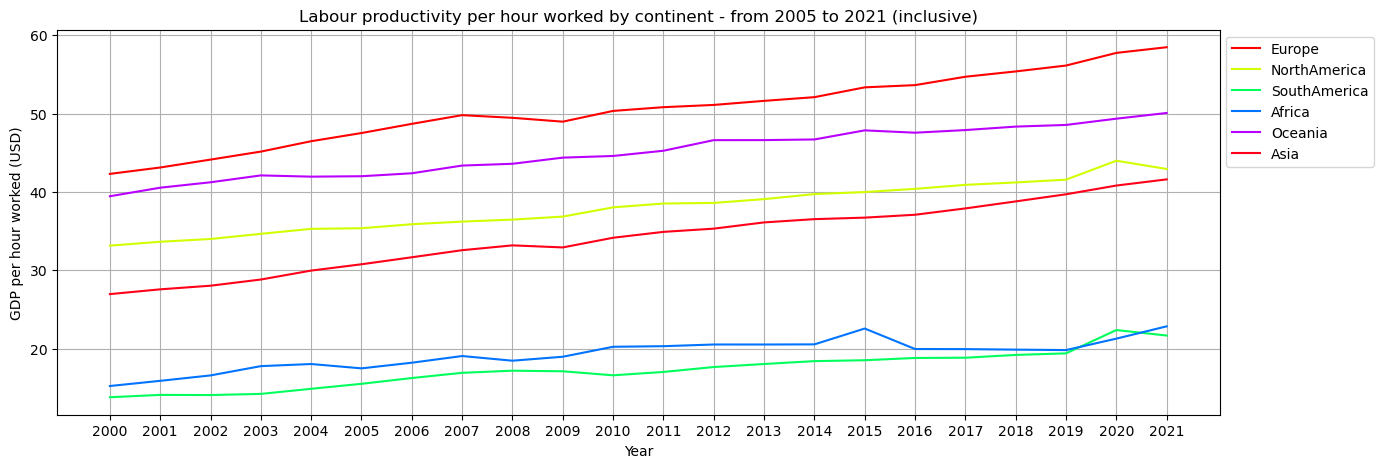

In [25]:
# plots every continent's labour productivity throughout time

worldRegionsStrings = ['Europe', 'NorthAmerica', 'SouthAmerica', 'Africa', 'Oceania', 'Asia']

plt.figure(figsize=(15, 5))

colorsRegions = plt.cm.hsv(np.linspace(0, 1, len(worldRegions)))

worldRegionsTimeSeries = [np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1)]

for row in range(numberOfRows):
    country = cleanedData.iloc[row]['LOCATION']
    for index, region in enumerate(worldRegions):
        if country in region:
            worldRegionsTimeSeries[index] = np.add(worldRegionsTimeSeries[index], cleanedData.iloc[row][1:-1])

for index, region in enumerate(worldRegions):
    plt.plot(cleanedData.columns[1:-1], worldRegionsTimeSeries[index]/len(region), c=colorsRegions[index], label=worldRegionsStrings[index])

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel('Year') 
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by continent - from 2000 to 2021 (inclusive)")

plt.show()

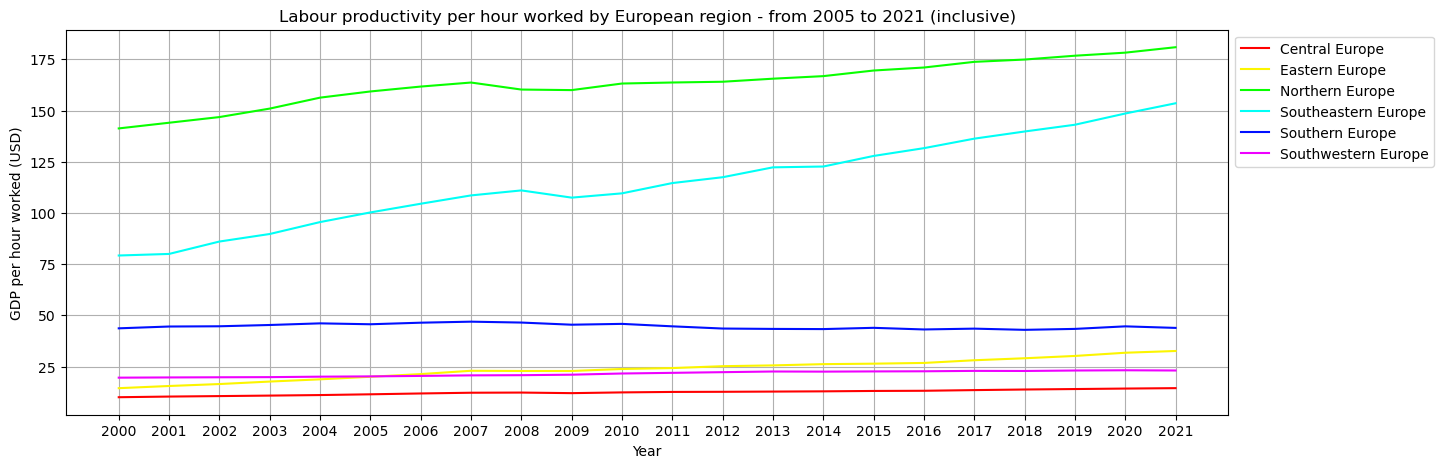

In [30]:
# plots every European region's labour productivity throughout time

plt.figure(figsize=(15, 5))

europeRegionsStrings = ['Central Europe', 'Eastern Europe', 'Northern Europe', 'Southeastern Europe', 'Southern Europe', 'Southwestern Europe', 'Western Europe']

colorsRegions = plt.cm.hsv(np.linspace(0, 1, len(Europe)))

europeSubregionsTimeSeries = [np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1)]

for row in range(numberOfRows):
    country = cleanedData.iloc[row]['LOCATION']
    for index, region in enumerate(Europe):
        if country in region:
            europeSubregionsTimeSeries[index] = np.add(europeSubregionsTimeSeries[index], cleanedData.iloc[row][1:-1])

for index, region in enumerate(worldRegions):
    plt.plot(cleanedData.columns[1:-1], europeSubregionsTimeSeries[index]/len(region), c=colorsRegions[index], label=europeRegionsStrings[index])

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel('Year') 
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by European region - from 2000 to 2021 (inclusive)")

plt.show()

2000    14.861829
2001    15.438275
2002    16.313284
2003    16.783858
2004    17.182034
2005    17.965425
2006    18.618248
2007    19.229785
2008    19.475667
2009    19.717737
2010    20.847786
2011    21.781488
2012    22.497211
2013    22.460713
2014     22.60739
2015    23.296069
2016    23.897609
2017    24.130056
2018    24.784139
2019    25.687153
2020    25.775778
2021    26.559335
Name: 3, dtype: object
2000    25.807631
2001    26.774537
2002    28.099669
2003    28.949717
2004    29.896572
2005     30.90332
2006    31.427151
2007    31.956235
2008    31.884464
2009    29.803838
2010    30.381448
2011    31.647165
2012    32.356397
2013    33.429929
2014    32.763303
2015    34.335121
2016    35.311994
2017    35.855539
2018    36.214321
2019    35.832518
2020    33.402665
2021    36.361268
Name: 18, dtype: object
2000    12.320277
2001    13.105868
2002    15.299585
2003    15.921944
2004    17.832453
2005    18.818376
2006    20.350859
2007    21.467073
2008    23.850073

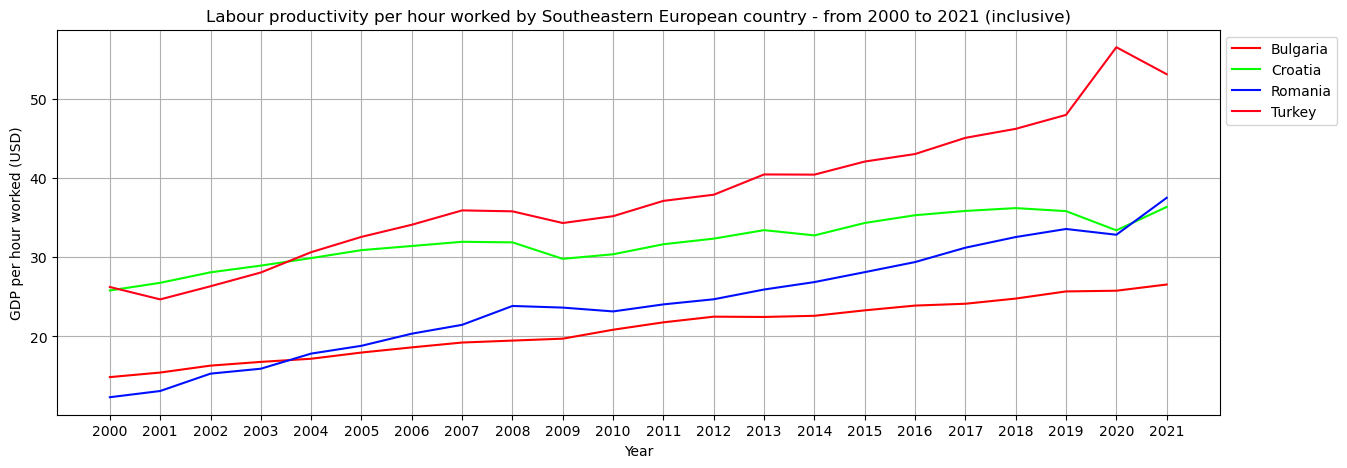

In [33]:
# plots every Southeastern European country's labour productivity throughout time

plt.figure(figsize=(15, 5))

SouthEasternEuropeStrings = ['Bulgaria', 'Croatia', 'Romania', 'Turkey']

colorsRegions = plt.cm.hsv(np.linspace(0, 1, len(SouthEasternEuropeStrings)))

europeSubregionsTimeSeries = [np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1)]

for row in range(numberOfRows):
    country = cleanedData.iloc[row]['LOCATION']
    for index, c in enumerate(SouthEasternEurope):
        if country == c:
            europeSubregionsTimeSeries[index] = np.add(europeSubregionsTimeSeries[index], cleanedData.iloc[row][1:-1])

for index, region in enumerate(SouthEasternEurope):
    plt.plot(cleanedData.columns[1:-1], europeSubregionsTimeSeries[index], c=colorsRegions[index], label=SouthEasternEuropeStrings[index])

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel('Year') 
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by Southeastern European country - from 2000 to 2021 (inclusive)")

plt.show()

In [22]:
# saves the cleaned productivity dataset under the Datasets folder

cleanedData.to_csv('../Datasets/cleaned_Productivity.csv', index=False)